In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("seaborn")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA

from tqdm import tqdm

/tmp/ipykernel_934792/153468927.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
data = io.loadmat("piececonst_r421_N1024_smooth1.mat")

In [3]:
data['coeff'].shape

(1024, 421, 421)

In [11]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) #* 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid

In [12]:
x_train, y_train, grid = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
x_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1000, 841), (1000, 841), (200, 841), (200, 841))

In [14]:
 y_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.023842  , 0.04120568, 0.05526998, 0.06702753, 0.07700054,
       0.08550371, 0.09274321, 0.09886049, 0.10395441, 0.10809344,
       0.11132339, 0.11367281, 0.11515706, 0.11578138, 0.11554299,
       0.11443236, 0.11243356, 0.10952373, 0.1056714 , 0.10083317,
       0.09494774, 0.08792534, 0.07962864, 0.06983828, 0.05819595,
       0.04412815, 0.02676614, 0.        , 0.        , 0.04124897,
       0.07347224, 0.10025565, 0.12290165, 0.14222358, 0.15875485,
       0.17286138, 0.18480113, 0.19475699, 0.20285633, 0.209184  ,
       0.21379211, 0.21670781, 0.21793929, 0.21747986, 0.21531

In [15]:
np.sqrt(841)

29.0

# Plotting: piecewise constant problem

In [16]:
x_train

array([[12., 12., 12., ...,  3.,  3.,  3.],
       [12., 12., 12., ...,  3.,  3.,  3.],
       [12., 12., 12., ..., 12., 12., 12.],
       ...,
       [ 3., 12., 12., ...,  3.,  3.,  3.],
       [ 3.,  3.,  3., ..., 12., 12., 12.],
       [ 3.,  3.,  3., ..., 12., 12., 12.]])

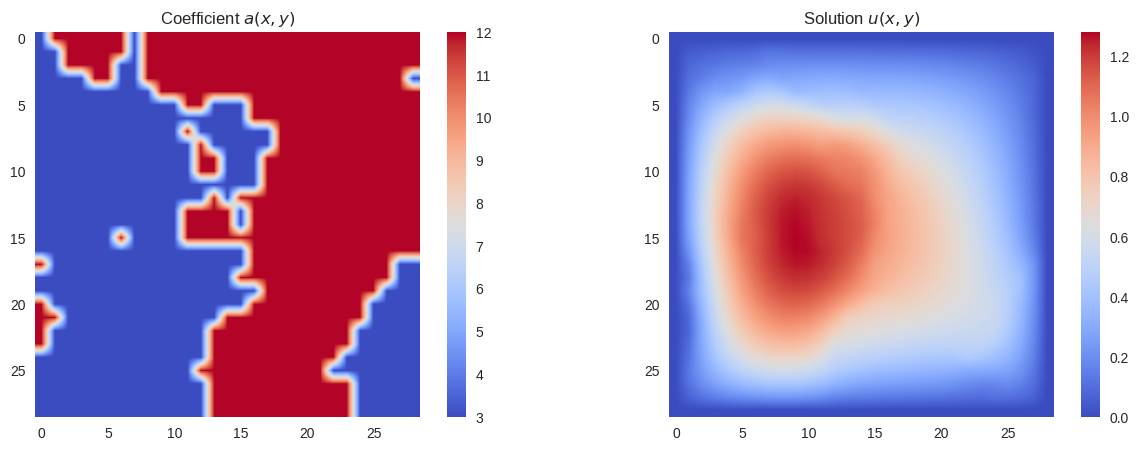

In [17]:
idx = 12
coef = x_train[idx].reshape(29,29)
sol = y_train[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $a(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

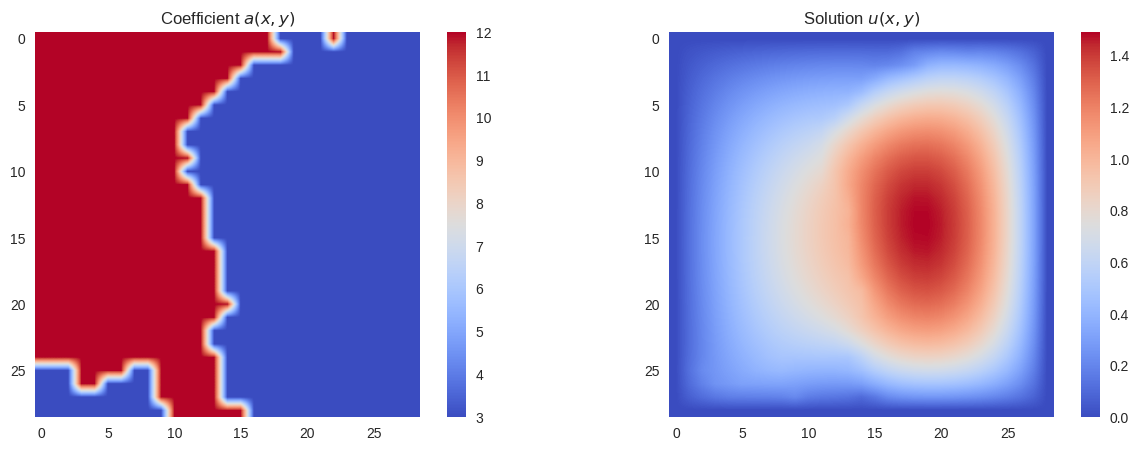

In [18]:
idx = 12
coef = x_test[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $a(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

In [19]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    
    model.fit(x_train_pca, y_train)
    pred= model.predict(x_test_pca)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

# Linear regression

In [20]:
model = LinearRegression()

n_pca = 10

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

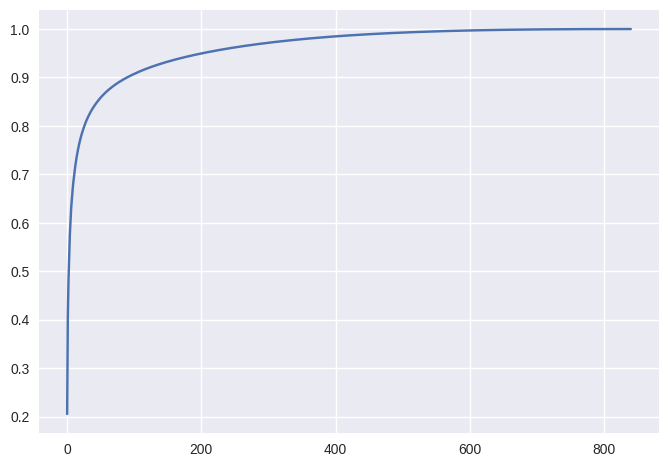

202

In [21]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

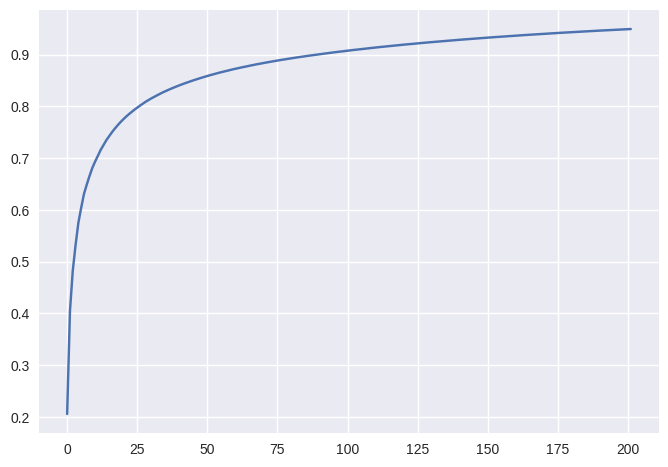

In [28]:
pca = PCA(n_components=202)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

In [29]:
x_train_pca.shape

(1000, 202)

In [22]:
pca_modes = np.arange(50, 90)
errors = []
for n_pca in pca_modes:
    pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    errors.append(e)

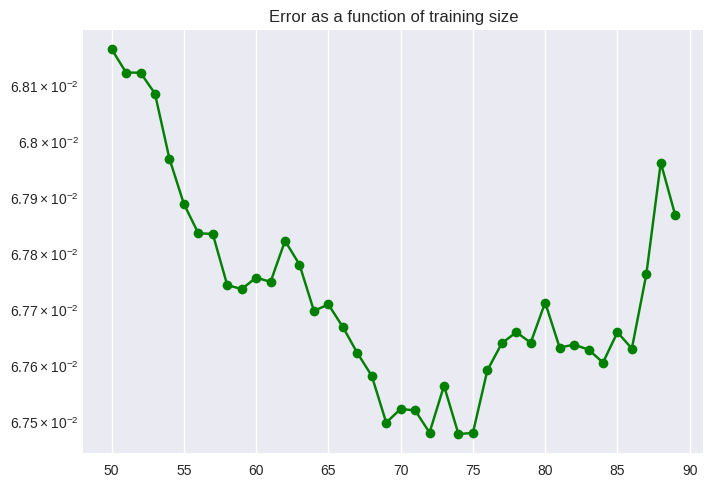

In [23]:
plt.figure()
plt.plot(pca_modes,errors, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")
plt.show()

In [24]:
best = np.argmin(errors)
pca_modes[best]

74

In [25]:
n_pca = pca_modes[best]

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

0.06749880610230528

/tmp/ipykernel_934792/2191536796.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


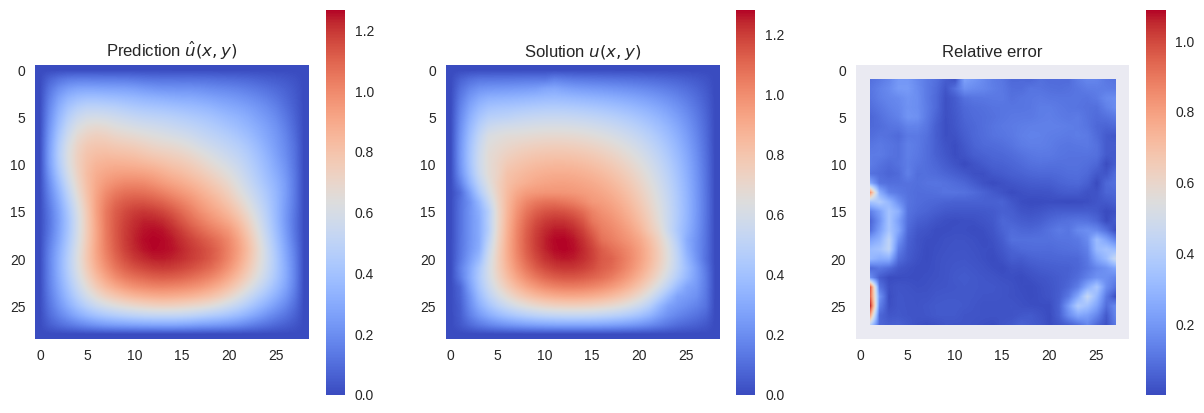

In [26]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

In [27]:
n_pca = 202

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

0.06938129368359912

# Ridge regression

In [20]:
model = Ridge(alpha = 1e-5)

In [21]:
pca_modes = np.arange(50, 100)
errors = []
for n_pca in pca_modes:
    pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    errors.append(e)

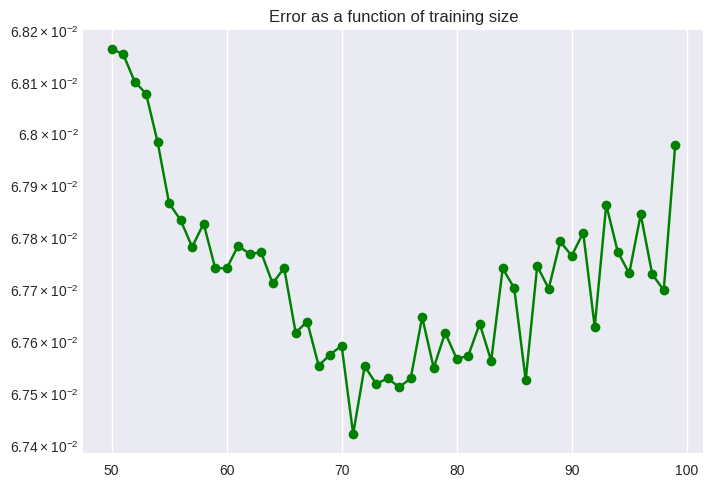

In [24]:
plt.figure()
plt.plot(pca_modes,errors, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")
plt.show()

In [25]:
best = np.argmin(errors)
pca_modes[best]

71

In [26]:
n_pca = pca_modes[best]

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e, model

(0.06752867177977437, Ridge(alpha=1e-05))

/tmp/ipykernel_15431/3324799619.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


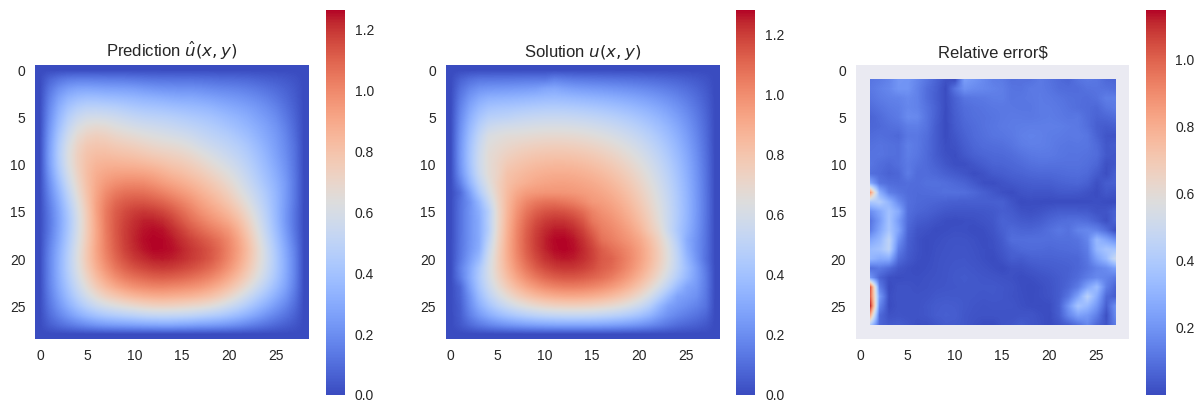

In [27]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

In [28]:
n_pca = 202

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

0.06931491936527856

# Polynomial Regression: quadratic

In [29]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

In [30]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [31]:
x_train_poly.shape[-1], x_train_poly.shape

(354903, (1000, 354903))

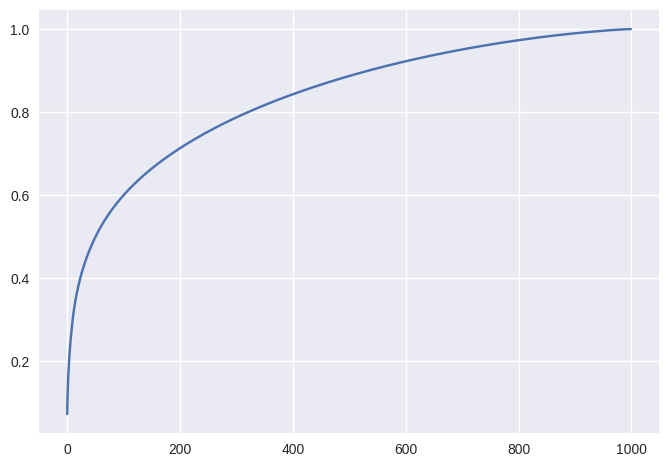

In [32]:
pca = PCA(n_components=1000)

x_train_pca = pca.fit_transform(x_train_poly)
x_test_pca = pca.transform(x_test_poly)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [33]:
n_pca

697

In [34]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.10075630155246279

/tmp/ipykernel_15431/3324799619.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


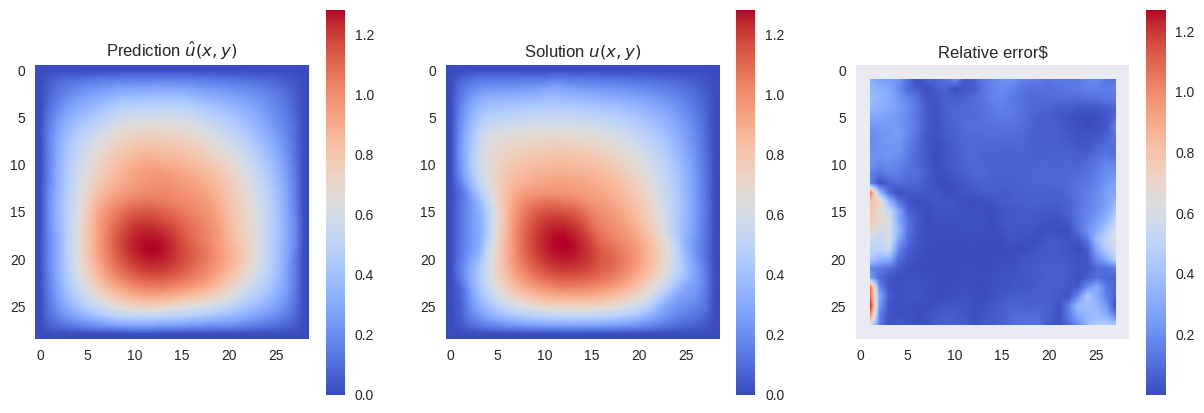

In [35]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Polynomial Ridge Regression: quadratic

In [36]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

In [37]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [38]:
x_train_poly.shape[-1], x_train_poly.shape

(354903, (1000, 354903))

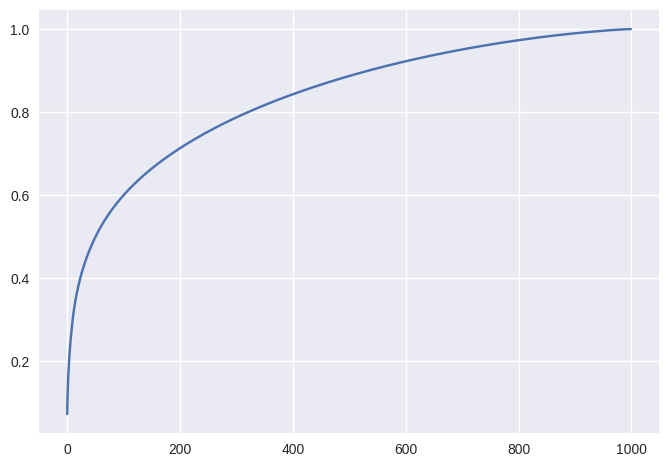

In [39]:
pca = PCA(n_components=1000)

x_train_pca = pca.fit_transform(x_train_poly)
x_test_pca = pca.transform(x_test_poly)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [40]:
n_pca

697

In [41]:
model = Ridge(1e-5)

pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.10075630159095791

/tmp/ipykernel_15431/3324799619.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


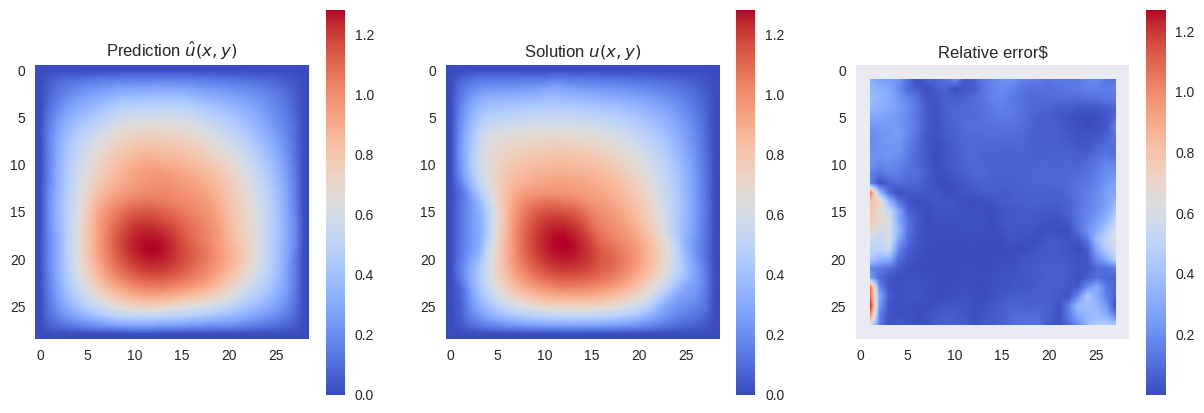

In [42]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: Matern 2.5

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [23]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

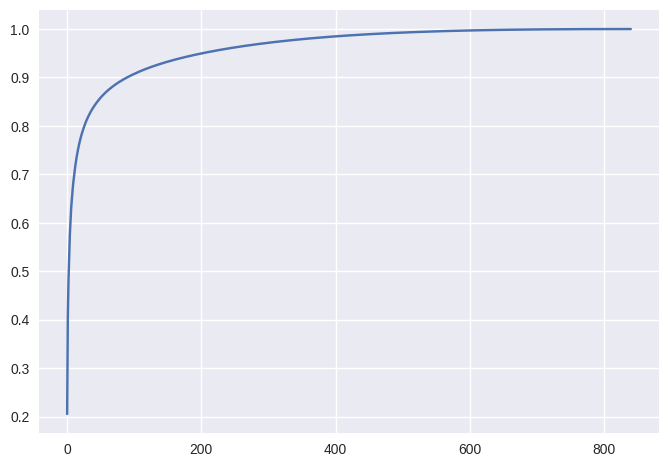

In [24]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [25]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [32]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    pred = []
    for i in range(y_train.shape[-1]):
        model.fit(x_train, y_train[:, i])
        pred.append(model.predict(x_test))
        print(model.kernel_)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return np.stack(pred), model

In [33]:
y_train.shape

(1000, 841)

In [34]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=204, nu=2.5)
Matern(length_scale=172, nu=2.5)
Matern(length_scale=158, nu=2.5)
Matern(length_scale=141, nu=2.5)
Matern(length_scale=131, nu=2.5)
Matern(length_scale=122, nu=2.5)
Matern(length_scale=118, nu=2.5)
Matern(length_scale=120, nu=2.5)
Matern(length_scale=114, nu=2.5)
Matern(length_scale=114, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=111, nu=2.5)
Matern(length_scale=112, nu=2.5)
Matern(length_scale=110, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=108, nu=2.5)
Matern(length_scale=107, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=112, nu=2.5)
Matern(length_scale=114, nu=2.5)
Matern(length_scale=117, nu=2.5)
Matern(length_scale=130, nu=2.5)
Matern(length_scale=136, nu=2.5)
Matern(length_scale=137, nu=2.5)
Matern(length_scale=150, nu=2.5)
Matern(length_scale=166, nu=2.5)
Matern(length_scale=199, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=172, nu=2.5)
Matern(length_scale=142, nu=2.5)
Matern(length_scale=126, nu=2.5)
Matern(length_scale=115, nu=2.5)
Matern(length_scale=108, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=99.1, nu=2.5)
Matern(length_scale=98.4, nu=2.5)
Matern(length_scale=101, nu=2.5)
Matern(length_scale=99.8, nu=2.5)
Matern(length_scale=97, nu=2.5)
Matern(length_scale=96.1, nu=2.5)
Matern(length_scale=97, nu=2.5)
Matern(length_scale=95, nu=2.5)
Matern(length_scale=96.9, nu=2.5)
Matern(length_scale=95.4, nu=2.5)
Matern(length_scale=94.1, nu=2.5)
Matern(length_scale=94.2, nu=2.5)
Matern(length_scale=97.5, nu=2.5)
Matern(length_scale=99.3, nu=2.5)
Matern(length_scale=101, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=110, nu=2.5)
Matern(length_scale=119, nu=2.5)
Matern(length_scale=127, nu=2.5)
Matern(length_scale=143, nu=2.5)
Matern(length_scale=164, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=147, nu=2.5)
Matern(length_scale=124, nu=2.5)
Matern(length_scale=112, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=99.6, nu=2.5)
Matern(length_scale=94.7, nu=2.5)
Matern(length_scale=92.5, nu=2.5)
Matern(length_scale=93.4, nu=2.5)
Matern(length_scale=94, nu=2.5)
Matern(length_scale=92.8, nu=2.5)
Matern(length_scale=90.7, nu=2.5)
Matern(length_scale=90.3, nu=2.5)
Matern(length_scale=87.5, nu=2.5)
Matern(length_scale=88, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=87.5, nu=2.5)
Matern(length_scale=87.9, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=90.4, nu=2.5)
Matern(length_scale=91.4, nu=2.5)
Matern(length_scale=91.3, nu=2.5)
Matern(length_scale=95.6, nu=2.5)
Matern(length_scale=99.3, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=110, nu=2.5)
Matern(length_scale=124, nu=2.5)
Matern(length_scale=145, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=135, nu=2.5)
Matern(length_scale=117, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=98.7, nu=2.5)
Matern(length_scale=95, nu=2.5)
Matern(length_scale=91.2, nu=2.5)
Matern(length_scale=91.2, nu=2.5)
Matern(length_scale=89.6, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=87.7, nu=2.5)
Matern(length_scale=86.6, nu=2.5)
Matern(length_scale=86.8, nu=2.5)
Matern(length_scale=86.2, nu=2.5)
Matern(length_scale=85.7, nu=2.5)
Matern(length_scale=85.9, nu=2.5)
Matern(length_scale=84.6, nu=2.5)
Matern(length_scale=85, nu=2.5)
Matern(length_scale=84.9, nu=2.5)
Matern(length_scale=86.6, nu=2.5)
Matern(length_scale=87.9, nu=2.5)
Matern(length_scale=89.9, nu=2.5)
Matern(length_scale=93.6, nu=2.5)
Matern(length_scale=97.1, nu=2.5)
Matern(length_scale=100, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=115, nu=2.5)
Matern(length_scale=128, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=129, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=101, nu=2.5)
Matern(length_scale=93.4, nu=2.5)
Matern(length_scale=91.7, nu=2.5)
Matern(length_scale=89.8, nu=2.5)
Matern(length_scale=88.5, nu=2.5)
Matern(length_scale=85.6, nu=2.5)
Matern(length_scale=84.7, nu=2.5)
Matern(length_scale=84.1, nu=2.5)
Matern(length_scale=82.5, nu=2.5)
Matern(length_scale=84.1, nu=2.5)
Matern(length_scale=84, nu=2.5)
Matern(length_scale=82.9, nu=2.5)
Matern(length_scale=82.4, nu=2.5)
Matern(length_scale=83.3, nu=2.5)
Matern(length_scale=83.2, nu=2.5)
Matern(length_scale=83.7, nu=2.5)
Matern(length_scale=83.7, nu=2.5)
Matern(length_scale=86.9, nu=2.5)
Matern(length_scale=89.3, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=91.2, nu=2.5)
Matern(length_scale=93.5, nu=2.5)
Matern(length_scale=96.1, nu=2.5)
Matern(length_scale=99.4, nu=2.5)
Matern(length_scale=111, nu=2.5)
Matern(length_scale=126, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=124, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=96.5, nu=2.5)
Matern(length_scale=91.3, nu=2.5)
Matern(length_scale=88.9, nu=2.5)
Matern(length_scale=87, nu=2.5)
Matern(length_scale=86.6, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=82.1, nu=2.5)
Matern(length_scale=79.9, nu=2.5)
Matern(length_scale=80.8, nu=2.5)
Matern(length_scale=80.4, nu=2.5)
Matern(length_scale=80.8, nu=2.5)
Matern(length_scale=80.7, nu=2.5)
Matern(length_scale=81.4, nu=2.5)
Matern(length_scale=80.9, nu=2.5)
Matern(length_scale=81.7, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=81.9, nu=2.5)
Matern(length_scale=83.5, nu=2.5)
Matern(length_scale=86.1, nu=2.5)
Matern(length_scale=88.1, nu=2.5)
Matern(length_scale=88.7, nu=2.5)
Matern(length_scale=91, nu=2.5)
Matern(length_scale=95.9, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=115, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=123, nu=2.5)
Matern(length_scale=102, nu=2.5)
Matern(length_scale=95.4, nu=2.5)
Matern(length_scale=89.1, nu=2.5)
Matern(length_scale=86.5, nu=2.5)
Matern(length_scale=84.7, nu=2.5)
Matern(length_scale=84.5, nu=2.5)
Matern(length_scale=82.9, nu=2.5)
Matern(length_scale=79.6, nu=2.5)
Matern(length_scale=79.6, nu=2.5)
Matern(length_scale=79.3, nu=2.5)
Matern(length_scale=79.5, nu=2.5)
Matern(length_scale=79.8, nu=2.5)
Matern(length_scale=78.7, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=79, nu=2.5)
Matern(length_scale=79.3, nu=2.5)
Matern(length_scale=80, nu=2.5)
Matern(length_scale=80.9, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=85.4, nu=2.5)
Matern(length_scale=87.3, nu=2.5)
Matern(length_scale=87.8, nu=2.5)
Matern(length_scale=92, nu=2.5)
Matern(length_scale=99.4, nu=2.5)
Matern(length_scale=117, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=117, nu=2.5)
Matern(length_scale=99.6, nu=2.5)
Matern(length_scale=92.6, nu=2.5)
Matern(length_scale=87.7, nu=2.5)
Matern(length_scale=84.9, nu=2.5)
Matern(length_scale=83.5, nu=2.5)
Matern(length_scale=81.6, nu=2.5)
Matern(length_scale=81, nu=2.5)
Matern(length_scale=79.5, nu=2.5)
Matern(length_scale=77.8, nu=2.5)
Matern(length_scale=76.5, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=77.4, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=76.4, nu=2.5)
Matern(length_scale=77.5, nu=2.5)
Matern(length_scale=78.9, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=79.7, nu=2.5)
Matern(length_scale=81.6, nu=2.5)
Matern(length_scale=82.8, nu=2.5)
Matern(length_scale=84.1, nu=2.5)
Matern(length_scale=85.8, nu=2.5)
Matern(length_scale=87.5, nu=2.5)
Matern(length_scale=91.7, nu=2.5)
Matern(length_scale=97.4, nu=2.5)
Matern(length_scale=115, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=113, nu=2.5)
Matern(length_scale=96.1, nu=2.5)
Matern(length_scale=88.5, nu=2.5)
Matern(length_scale=86.4, nu=2.5)
Matern(length_scale=83.3, nu=2.5)
Matern(length_scale=82.5, nu=2.5)
Matern(length_scale=80.7, nu=2.5)
Matern(length_scale=77.3, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=77.5, nu=2.5)
Matern(length_scale=76.7, nu=2.5)
Matern(length_scale=76.3, nu=2.5)
Matern(length_scale=76.2, nu=2.5)
Matern(length_scale=75.2, nu=2.5)
Matern(length_scale=75.2, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=78.1, nu=2.5)
Matern(length_scale=77.3, nu=2.5)
Matern(length_scale=78.1, nu=2.5)
Matern(length_scale=80.2, nu=2.5)
Matern(length_scale=82.2, nu=2.5)
Matern(length_scale=84.6, nu=2.5)
Matern(length_scale=84.9, nu=2.5)
Matern(length_scale=87.4, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=99, nu=2.5)
Matern(length_scale=109, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=94.8, nu=2.5)
Matern(length_scale=86.9, nu=2.5)
Matern(length_scale=85.7, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=80.4, nu=2.5)
Matern(length_scale=79.8, nu=2.5)
Matern(length_scale=77.6, nu=2.5)
Matern(length_scale=76.7, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=76.4, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=75.5, nu=2.5)
Matern(length_scale=74.8, nu=2.5)
Matern(length_scale=74.6, nu=2.5)
Matern(length_scale=75.5, nu=2.5)
Matern(length_scale=76.6, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=77.5, nu=2.5)
Matern(length_scale=78.9, nu=2.5)
Matern(length_scale=81.6, nu=2.5)
Matern(length_scale=83.2, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=85.3, nu=2.5)
Matern(length_scale=88.6, nu=2.5)
Matern(length_scale=95.9, nu=2.5)
Matern(length_scale=111, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=92.4, nu=2.5)
Matern(length_scale=86.6, nu=2.5)
Matern(length_scale=85.8, nu=2.5)
Matern(length_scale=81.8, nu=2.5)
Matern(length_scale=78.9, nu=2.5)
Matern(length_scale=78.1, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=77.1, nu=2.5)
Matern(length_scale=75.8, nu=2.5)
Matern(length_scale=74.7, nu=2.5)
Matern(length_scale=74.8, nu=2.5)
Matern(length_scale=74.6, nu=2.5)
Matern(length_scale=74.5, nu=2.5)
Matern(length_scale=73.4, nu=2.5)
Matern(length_scale=75.5, nu=2.5)
Matern(length_scale=76.5, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=77, nu=2.5)
Matern(length_scale=78.2, nu=2.5)
Matern(length_scale=79.3, nu=2.5)
Matern(length_scale=80.9, nu=2.5)
Matern(length_scale=84.7, nu=2.5)
Matern(length_scale=86.8, nu=2.5)
Matern(length_scale=89.4, nu=2.5)
Matern(length_scale=92, nu=2.5)
Matern(length_scale=106, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=89.8, nu=2.5)
Matern(length_scale=84.4, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=80.1, nu=2.5)
Matern(length_scale=78.6, nu=2.5)
Matern(length_scale=78.9, nu=2.5)
Matern(length_scale=77.6, nu=2.5)
Matern(length_scale=75.8, nu=2.5)
Matern(length_scale=75.2, nu=2.5)
Matern(length_scale=74.5, nu=2.5)
Matern(length_scale=74.6, nu=2.5)
Matern(length_scale=74, nu=2.5)
Matern(length_scale=73.5, nu=2.5)
Matern(length_scale=75.9, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=76.1, nu=2.5)
Matern(length_scale=77, nu=2.5)
Matern(length_scale=77.8, nu=2.5)
Matern(length_scale=78.5, nu=2.5)
Matern(length_scale=79.2, nu=2.5)
Matern(length_scale=82.1, nu=2.5)
Matern(length_scale=84.7, nu=2.5)
Matern(length_scale=86.8, nu=2.5)
Matern(length_scale=89.9, nu=2.5)
Matern(length_scale=92.4, nu=2.5)
Matern(length_scale=107, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=110, nu=2.5)
Matern(length_scale=89.1, nu=2.5)
Matern(length_scale=84.5, nu=2.5)
Matern(length_scale=84, nu=2.5)
Matern(length_scale=81.6, nu=2.5)
Matern(length_scale=79.7, nu=2.5)
Matern(length_scale=79.4, nu=2.5)
Matern(length_scale=78.9, nu=2.5)
Matern(length_scale=77.8, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=75.3, nu=2.5)
Matern(length_scale=74.6, nu=2.5)
Matern(length_scale=74.5, nu=2.5)
Matern(length_scale=73.5, nu=2.5)
Matern(length_scale=74, nu=2.5)
Matern(length_scale=75.6, nu=2.5)
Matern(length_scale=76.2, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=77.8, nu=2.5)
Matern(length_scale=78.4, nu=2.5)
Matern(length_scale=79.4, nu=2.5)
Matern(length_scale=83.3, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=87.3, nu=2.5)
Matern(length_scale=90.9, nu=2.5)
Matern(length_scale=92.6, nu=2.5)
Matern(length_scale=106, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=108, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=83.9, nu=2.5)
Matern(length_scale=82.6, nu=2.5)
Matern(length_scale=82.1, nu=2.5)
Matern(length_scale=80.4, nu=2.5)
Matern(length_scale=79.3, nu=2.5)
Matern(length_scale=77.3, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=76.3, nu=2.5)
Matern(length_scale=75.3, nu=2.5)
Matern(length_scale=74.9, nu=2.5)
Matern(length_scale=75, nu=2.5)
Matern(length_scale=73.9, nu=2.5)
Matern(length_scale=73.8, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=75.4, nu=2.5)
Matern(length_scale=75.5, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=75.5, nu=2.5)
Matern(length_scale=77.7, nu=2.5)
Matern(length_scale=78.6, nu=2.5)
Matern(length_scale=80, nu=2.5)
Matern(length_scale=82.2, nu=2.5)
Matern(length_scale=84, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=87.3, nu=2.5)
Matern(length_scale=91, nu=2.5)
Matern(length_scale=91.8, nu=2.5)
Matern(length_scale=108, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=88.4, nu=2.5)
Matern(length_scale=83.4, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=82.8, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=79.8, nu=2.5)
Matern(length_scale=78.7, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=75.6, nu=2.5)
Matern(length_scale=75.3, nu=2.5)
Matern(length_scale=75, nu=2.5)
Matern(length_scale=74.4, nu=2.5)
Matern(length_scale=73.5, nu=2.5)
Matern(length_scale=73.8, nu=2.5)
Matern(length_scale=74.2, nu=2.5)
Matern(length_scale=75.4, nu=2.5)
Matern(length_scale=76.2, nu=2.5)
Matern(length_scale=76.1, nu=2.5)
Matern(length_scale=77.9, nu=2.5)
Matern(length_scale=78.6, nu=2.5)
Matern(length_scale=79.5, nu=2.5)
Matern(length_scale=82.5, nu=2.5)
Matern(length_scale=84.1, nu=2.5)
Matern(length_scale=87.1, nu=2.5)
Matern(length_scale=90.1, nu=2.5)
Matern(length_scale=93, nu=2.5)
Matern(length_scale=105, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=108, nu=2.5)
Matern(length_scale=91.9, nu=2.5)
Matern(length_scale=86.3, nu=2.5)
Matern(length_scale=82.3, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=80.1, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=77.7, nu=2.5)
Matern(length_scale=76.5, nu=2.5)
Matern(length_scale=75.6, nu=2.5)
Matern(length_scale=75.3, nu=2.5)
Matern(length_scale=74.5, nu=2.5)
Matern(length_scale=74.3, nu=2.5)
Matern(length_scale=74.2, nu=2.5)
Matern(length_scale=75, nu=2.5)
Matern(length_scale=75.1, nu=2.5)
Matern(length_scale=75.7, nu=2.5)
Matern(length_scale=75.7, nu=2.5)
Matern(length_scale=78, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=79.9, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=83.2, nu=2.5)
Matern(length_scale=84.8, nu=2.5)
Matern(length_scale=88.4, nu=2.5)
Matern(length_scale=93.7, nu=2.5)
Matern(length_scale=107, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=110, nu=2.5)
Matern(length_scale=95.4, nu=2.5)
Matern(length_scale=91.3, nu=2.5)
Matern(length_scale=87.3, nu=2.5)
Matern(length_scale=84.2, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=80, nu=2.5)
Matern(length_scale=79.6, nu=2.5)
Matern(length_scale=77.2, nu=2.5)
Matern(length_scale=76.6, nu=2.5)
Matern(length_scale=76.2, nu=2.5)
Matern(length_scale=74.7, nu=2.5)
Matern(length_scale=75.7, nu=2.5)
Matern(length_scale=75.2, nu=2.5)
Matern(length_scale=75.2, nu=2.5)
Matern(length_scale=75.8, nu=2.5)
Matern(length_scale=76.2, nu=2.5)
Matern(length_scale=76.7, nu=2.5)
Matern(length_scale=77.4, nu=2.5)
Matern(length_scale=78.8, nu=2.5)
Matern(length_scale=80.3, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=83.6, nu=2.5)
Matern(length_scale=84.5, nu=2.5)
Matern(length_scale=87.5, nu=2.5)
Matern(length_scale=94, nu=2.5)
Matern(length_scale=113, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=110, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=96.1, nu=2.5)
Matern(length_scale=94.2, nu=2.5)
Matern(length_scale=88.4, nu=2.5)
Matern(length_scale=85.8, nu=2.5)
Matern(length_scale=83.4, nu=2.5)
Matern(length_scale=81.3, nu=2.5)
Matern(length_scale=79.3, nu=2.5)
Matern(length_scale=77.9, nu=2.5)
Matern(length_scale=76.6, nu=2.5)
Matern(length_scale=76.3, nu=2.5)
Matern(length_scale=76.1, nu=2.5)
Matern(length_scale=75.6, nu=2.5)
Matern(length_scale=75.3, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=76.6, nu=2.5)
Matern(length_scale=76.5, nu=2.5)
Matern(length_scale=76.7, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=78.5, nu=2.5)
Matern(length_scale=80.2, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=87, nu=2.5)
Matern(length_scale=88.1, nu=2.5)
Matern(length_scale=92.9, nu=2.5)
Matern(length_scale=113, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=119, nu=2.5)
Matern(length_scale=98.5, nu=2.5)
Matern(length_scale=93.5, nu=2.5)
Matern(length_scale=89.3, nu=2.5)
Matern(length_scale=86.9, nu=2.5)
Matern(length_scale=84.2, nu=2.5)
Matern(length_scale=82.4, nu=2.5)
Matern(length_scale=81.5, nu=2.5)
Matern(length_scale=79.5, nu=2.5)
Matern(length_scale=76.9, nu=2.5)
Matern(length_scale=76.6, nu=2.5)
Matern(length_scale=76.3, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=75.9, nu=2.5)
Matern(length_scale=76.8, nu=2.5)
Matern(length_scale=77.5, nu=2.5)
Matern(length_scale=77, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=77.8, nu=2.5)
Matern(length_scale=78.8, nu=2.5)
Matern(length_scale=79.9, nu=2.5)
Matern(length_scale=81.2, nu=2.5)
Matern(length_scale=82.2, nu=2.5)
Matern(length_scale=86.4, nu=2.5)
Matern(length_scale=91.4, nu=2.5)
Matern(length_scale=91.6, nu=2.5)
Matern(length_scale=96.6, nu=2.5)
Matern(length_scale=115, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=120, nu=2.5)
Matern(length_scale=99.5, nu=2.5)
Matern(length_scale=92.4, nu=2.5)
Matern(length_scale=90, nu=2.5)
Matern(length_scale=87.6, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=82.9, nu=2.5)
Matern(length_scale=81.6, nu=2.5)
Matern(length_scale=80.6, nu=2.5)
Matern(length_scale=78.7, nu=2.5)
Matern(length_scale=77.9, nu=2.5)
Matern(length_scale=77.9, nu=2.5)
Matern(length_scale=77.1, nu=2.5)
Matern(length_scale=76.4, nu=2.5)
Matern(length_scale=77.2, nu=2.5)
Matern(length_scale=77.6, nu=2.5)
Matern(length_scale=78.1, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=80, nu=2.5)
Matern(length_scale=81.7, nu=2.5)
Matern(length_scale=83.4, nu=2.5)
Matern(length_scale=85.6, nu=2.5)
Matern(length_scale=88.9, nu=2.5)
Matern(length_scale=92.2, nu=2.5)
Matern(length_scale=93.3, nu=2.5)
Matern(length_scale=102, nu=2.5)
Matern(length_scale=119, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=114, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=93.1, nu=2.5)
Matern(length_scale=91.1, nu=2.5)
Matern(length_scale=88.5, nu=2.5)
Matern(length_scale=85.2, nu=2.5)
Matern(length_scale=84.2, nu=2.5)
Matern(length_scale=82.9, nu=2.5)
Matern(length_scale=81.2, nu=2.5)
Matern(length_scale=79.9, nu=2.5)
Matern(length_scale=78.7, nu=2.5)
Matern(length_scale=79.6, nu=2.5)
Matern(length_scale=78.8, nu=2.5)
Matern(length_scale=79, nu=2.5)
Matern(length_scale=77.7, nu=2.5)
Matern(length_scale=78.1, nu=2.5)
Matern(length_scale=79.8, nu=2.5)
Matern(length_scale=80.6, nu=2.5)
Matern(length_scale=81.7, nu=2.5)
Matern(length_scale=83.2, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=87.7, nu=2.5)
Matern(length_scale=90, nu=2.5)
Matern(length_scale=93.1, nu=2.5)
Matern(length_scale=98.4, nu=2.5)
Matern(length_scale=103, nu=2.5)
Matern(length_scale=118, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=96.6, nu=2.5)
Matern(length_scale=93.5, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=85.7, nu=2.5)
Matern(length_scale=85.6, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=82.5, nu=2.5)
Matern(length_scale=80, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=79.1, nu=2.5)
Matern(length_scale=79.6, nu=2.5)
Matern(length_scale=81.1, nu=2.5)
Matern(length_scale=80.5, nu=2.5)
Matern(length_scale=80.3, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=83.1, nu=2.5)
Matern(length_scale=83.4, nu=2.5)
Matern(length_scale=84, nu=2.5)
Matern(length_scale=86.6, nu=2.5)
Matern(length_scale=89.4, nu=2.5)
Matern(length_scale=91.1, nu=2.5)
Matern(length_scale=94.8, nu=2.5)
Matern(length_scale=100, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=126, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=126, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=103, nu=2.5)
Matern(length_scale=97.9, nu=2.5)
Matern(length_scale=93.1, nu=2.5)
Matern(length_scale=89.1, nu=2.5)
Matern(length_scale=86.4, nu=2.5)
Matern(length_scale=85.3, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=84.7, nu=2.5)
Matern(length_scale=82.5, nu=2.5)
Matern(length_scale=80.8, nu=2.5)
Matern(length_scale=81.5, nu=2.5)
Matern(length_scale=82, nu=2.5)
Matern(length_scale=82.4, nu=2.5)
Matern(length_scale=83.4, nu=2.5)
Matern(length_scale=82.6, nu=2.5)
Matern(length_scale=83.9, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=86, nu=2.5)
Matern(length_scale=87, nu=2.5)
Matern(length_scale=88.9, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=90.6, nu=2.5)
Matern(length_scale=91.8, nu=2.5)
Matern(length_scale=98.3, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=111, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=134, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=128, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=98.4, nu=2.5)
Matern(length_scale=93.2, nu=2.5)
Matern(length_scale=89, nu=2.5)
Matern(length_scale=85.7, nu=2.5)
Matern(length_scale=86.7, nu=2.5)
Matern(length_scale=86.3, nu=2.5)
Matern(length_scale=83.9, nu=2.5)
Matern(length_scale=83.9, nu=2.5)
Matern(length_scale=83.9, nu=2.5)
Matern(length_scale=84.3, nu=2.5)
Matern(length_scale=85.1, nu=2.5)
Matern(length_scale=85.7, nu=2.5)
Matern(length_scale=86.3, nu=2.5)
Matern(length_scale=85.2, nu=2.5)
Matern(length_scale=86.3, nu=2.5)
Matern(length_scale=88.9, nu=2.5)
Matern(length_scale=92, nu=2.5)
Matern(length_scale=96.3, nu=2.5)
Matern(length_scale=97.2, nu=2.5)
Matern(length_scale=103, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=139, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=138, nu=2.5)
Matern(length_scale=125, nu=2.5)
Matern(length_scale=113, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=103, nu=2.5)
Matern(length_scale=100, nu=2.5)
Matern(length_scale=95.4, nu=2.5)
Matern(length_scale=91.6, nu=2.5)
Matern(length_scale=87.9, nu=2.5)
Matern(length_scale=87.1, nu=2.5)
Matern(length_scale=86.5, nu=2.5)
Matern(length_scale=87.5, nu=2.5)
Matern(length_scale=88.5, nu=2.5)
Matern(length_scale=88, nu=2.5)
Matern(length_scale=88.1, nu=2.5)
Matern(length_scale=89.4, nu=2.5)
Matern(length_scale=89.4, nu=2.5)
Matern(length_scale=92, nu=2.5)
Matern(length_scale=91.6, nu=2.5)
Matern(length_scale=91.2, nu=2.5)
Matern(length_scale=97, nu=2.5)
Matern(length_scale=102, nu=2.5)
Matern(length_scale=104, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern(length_scale=110, nu=2.5)
Matern(length_scale=118, nu=2.5)
Matern(length_scale=129, nu=2.5)
Matern(length_scale=152, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=159, nu=2.5)
Matern(length_scale=138, nu=2.5)
Matern(length_scale=123, nu=2.5)
Matern(length_scale=118, nu=2.5)
Matern(length_scale=112, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=105, nu=2.5)
Matern(length_scale=100, nu=2.5)
Matern(length_scale=95.1, nu=2.5)
Matern(length_scale=96.5, nu=2.5)
Matern(length_scale=95.7, nu=2.5)
Matern(length_scale=92.7, nu=2.5)
Matern(length_scale=97.9, nu=2.5)
Matern(length_scale=97.5, nu=2.5)
Matern(length_scale=99.7, nu=2.5)
Matern(length_scale=98.8, nu=2.5)
Matern(length_scale=101, nu=2.5)
Matern(length_scale=102, nu=2.5)
Matern(length_scale=101, nu=2.5)
Matern(length_scale=104, nu=2.5)
Matern(length_scale=109, nu=2.5)
Matern(length_scale=113, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=116, nu=2.5)
Matern(length_scale=124, nu=2.5)
Matern(length_scale=141, nu=2.5)
Matern(length_scale=177, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=199, nu=2.5)
Matern(length_scale=162, nu=2.5)
Matern(length_scale=147, nu=2.5)
Matern(length_scale=131, nu=2.5)
Matern(length_scale=122, nu=2.5)
Matern(length_scale=119, nu=2.5)
Matern(length_scale=121, nu=2.5)
Matern(length_scale=119, nu=2.5)
Matern(length_scale=115, nu=2.5)
Matern(length_scale=114, nu=2.5)
Matern(length_scale=113, nu=2.5)
Matern(length_scale=112, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=107, nu=2.5)
Matern(length_scale=108, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=106, nu=2.5)
Matern(length_scale=111, nu=2.5)
Matern(length_scale=112, nu=2.5)
Matern(length_scale=121, nu=2.5)
Matern(length_scale=121, nu=2.5)
Matern(length_scale=133, nu=2.5)
Matern(length_scale=126, nu=2.5)
Matern(length_scale=137, nu=2.5)
Matern(length_scale=143, nu=2.5)
Matern(length_scale=164, nu=2.5)
Matern(length_scale=207, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern(length_scale=1e+05, nu=2.5)
Matern(length_scale=1e+05, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (841,200) (200,841) 

In [35]:
pred = pred.T
pred.shape

(200, 841)

In [26]:
model.kernel_, e

(Matern(length_scale=90.4, nu=2.5), 0.02900390910085613)

In [37]:
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.02896977827639181

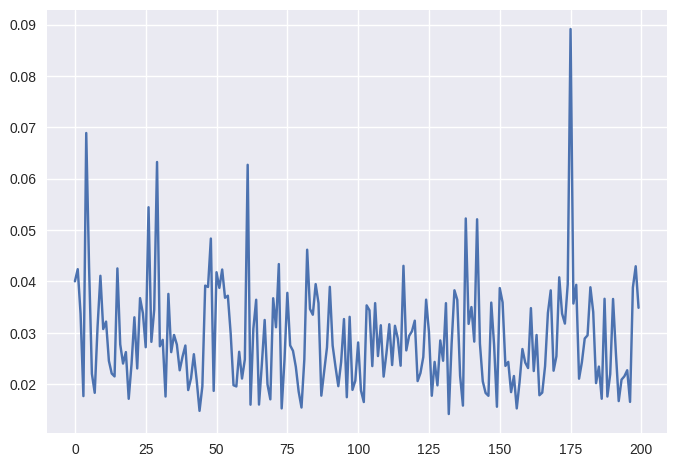

In [41]:
e = np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

plt.plot(e)

In [ ]:
pred.shape

/tmp/ipykernel_277255/2191536796.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


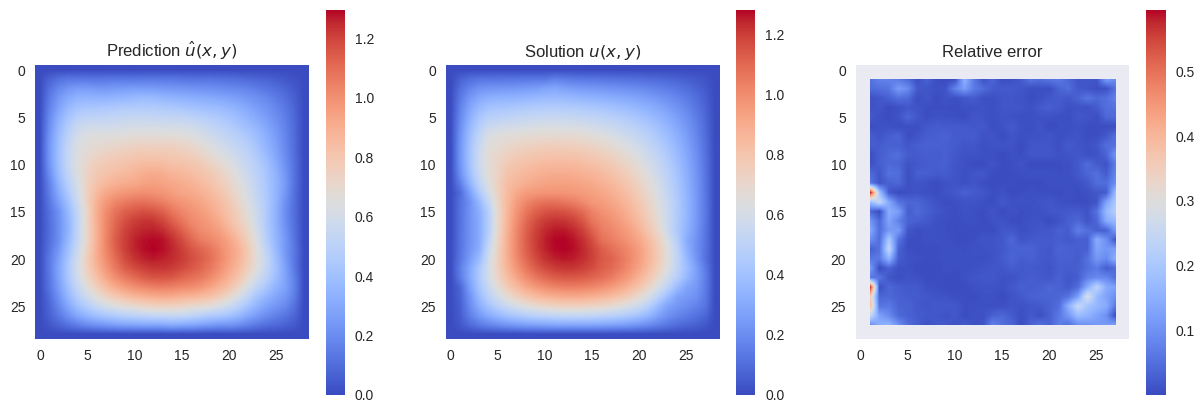

In [27]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: RBF

In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [50]:
#kernel = Matern(nu = 2.5)
kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

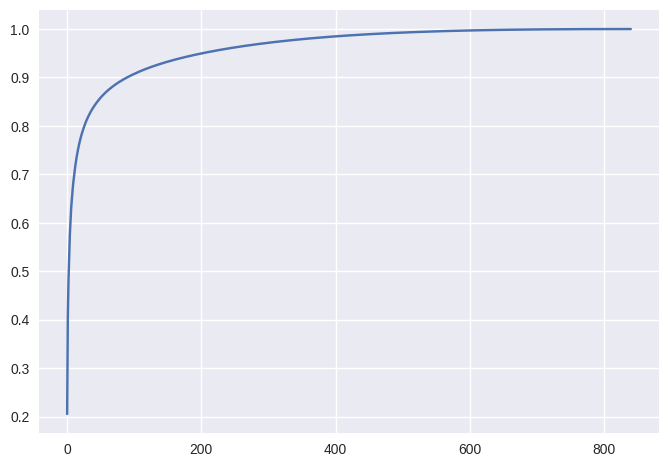

In [51]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [52]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [53]:
model.kernel_, e

(RBF(length_scale=55.4), 0.029821685805713274)

/tmp/ipykernel_15431/3324799619.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


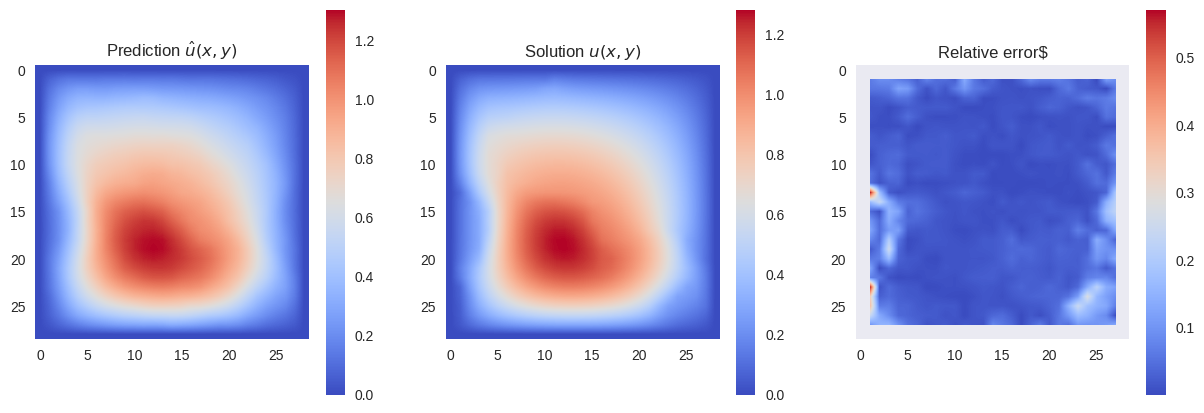

In [54]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: exponential

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [56]:
kernel = Matern(nu = 0.5)
#kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

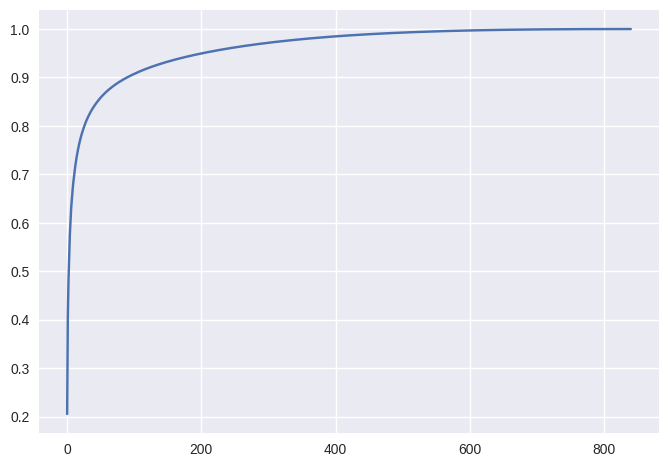

In [57]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [58]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [59]:
model.kernel_, e

(Matern(length_scale=6.66e+03, nu=0.5), 0.0346222370630789)

/tmp/ipykernel_15431/3324799619.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


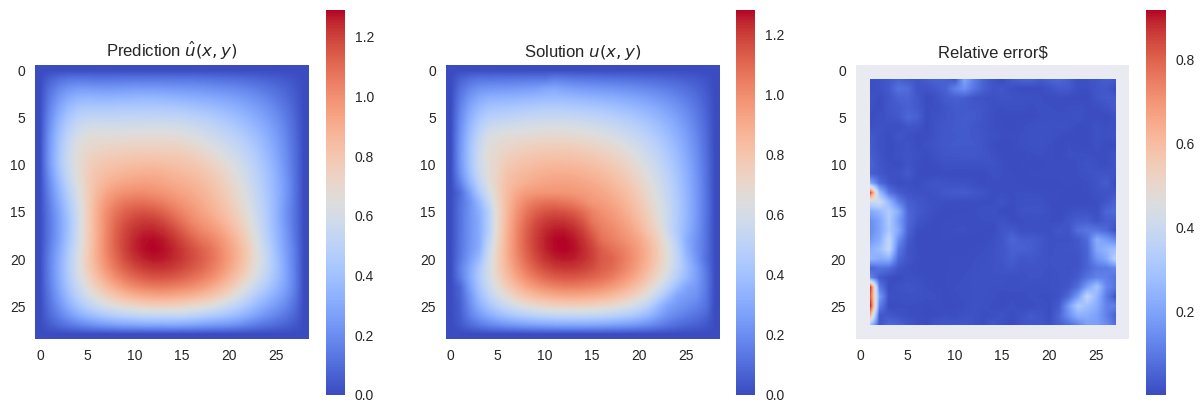

In [60]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: RationalQuadratic

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

In [13]:
#kernel = Matern(nu = 0.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

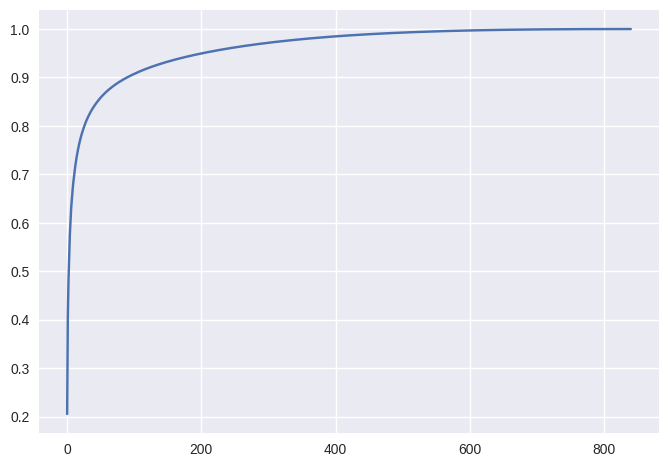

In [14]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [15]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [16]:
model.kernel_, e

(RationalQuadratic(alpha=0.0164, length_scale=146), 0.0287438565064801)

In [23]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    pred = []
    for i in tqdm(range(y_train.shape[-1])):
        model.fit(x_train, y_train[:, i])
        pred.append(model.predict(x_test))
        print(model.kernel_)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return np.stack(pred), model

In [24]:
y_train.shape

(1000, 841)

In [25]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)


  0%|                                                   | 0/841 [00:00<?, ?it/s]/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  0%|                                           | 1/841 [00:00<08:41,  1.61it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  0%|                                           | 2/841 [00:01<08:21,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  0%|▏                                          | 3/841 [00:01<08:24,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  0%|▏                                          | 4/841 [00:02<08:39,  1.61it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▎                                          | 5/841 [00:03<08:35,  1.62it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▎                                          | 6/841 [00:03<08:30,  1.64it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▎                                          | 7/841 [00:04<08:24,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▍                                          | 8/841 [00:04<08:25,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▍                                          | 9/841 [00:05<08:20,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▍                                         | 10/841 [00:06<08:19,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▌                                         | 11/841 [00:06<08:19,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  1%|▌                                         | 12/841 [00:07<08:16,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▋                                         | 13/841 [00:07<08:14,  1.68it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▋                                         | 14/841 [00:08<08:15,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▋                                         | 15/841 [00:09<08:12,  1.68it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▊                                         | 16/841 [00:09<08:18,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▊                                         | 17/841 [00:10<08:19,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▉                                         | 18/841 [00:10<08:21,  1.64it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▉                                         | 19/841 [00:11<08:17,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▉                                         | 20/841 [00:12<08:13,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|█                                         | 21/841 [00:12<08:09,  1.68it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█                                         | 22/841 [00:13<08:05,  1.69it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▏                                        | 23/841 [00:13<08:03,  1.69it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▏                                        | 24/841 [00:14<08:05,  1.68it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▏                                        | 25/841 [00:15<08:07,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▎                                        | 26/841 [00:15<08:13,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▎                                        | 27/841 [00:16<08:09,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▍                                        | 28/841 [00:16<08:08,  1.66it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  3%|█▍                                        | 29/841 [00:17<08:07,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  4%|█▍                                        | 30/841 [00:18<08:05,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


  4%|█▌                                        | 31/841 [00:20<15:36,  1.16s/it]

RationalQuadratic(alpha=0.0007, length_scale=696)


  4%|█▌                                        | 32/841 [00:22<19:18,  1.43s/it]

RationalQuadratic(alpha=0.0014, length_scale=499)


  4%|█▋                                        | 33/841 [00:24<22:31,  1.67s/it]

RationalQuadratic(alpha=0.00241, length_scale=404)


  4%|█▋                                        | 34/841 [00:26<21:08,  1.57s/it]

RationalQuadratic(alpha=0.00304, length_scale=329)


  4%|█▋                                        | 35/841 [00:27<20:07,  1.50s/it]

RationalQuadratic(alpha=0.00337, length_scale=297)


  4%|█▊                                        | 36/841 [00:28<19:22,  1.44s/it]

RationalQuadratic(alpha=0.00375, length_scale=267)


  4%|█▊                                        | 37/841 [00:30<18:50,  1.41s/it]

RationalQuadratic(alpha=0.00393, length_scale=254)


  5%|█▉                                        | 38/841 [00:31<18:31,  1.38s/it]

RationalQuadratic(alpha=0.00386, length_scale=259)


  5%|█▉                                        | 39/841 [00:32<18:19,  1.37s/it]

RationalQuadratic(alpha=0.00408, length_scale=245)


  5%|█▉                                        | 40/841 [00:34<18:05,  1.35s/it]

RationalQuadratic(alpha=0.00407, length_scale=246)


  5%|██                                        | 41/841 [00:35<17:55,  1.34s/it]

RationalQuadratic(alpha=0.00436, length_scale=229)


  5%|██                                        | 42/841 [00:36<17:50,  1.34s/it]

RationalQuadratic(alpha=0.00407, length_scale=246)


  5%|██▏                                       | 43/841 [00:38<17:46,  1.34s/it]

RationalQuadratic(alpha=0.00431, length_scale=232)


  5%|██▏                                       | 44/841 [00:39<17:41,  1.33s/it]

RationalQuadratic(alpha=0.00427, length_scale=234)


  5%|██▏                                       | 45/841 [00:40<17:41,  1.33s/it]

RationalQuadratic(alpha=0.00435, length_scale=230)


  5%|██▎                                       | 46/841 [00:42<17:41,  1.33s/it]

RationalQuadratic(alpha=0.0046, length_scale=218)


  6%|██▎                                       | 47/841 [00:43<17:41,  1.34s/it]

RationalQuadratic(alpha=0.00449, length_scale=223)


  6%|██▍                                       | 48/841 [00:45<21:46,  1.65s/it]

RationalQuadratic(alpha=0.0068, length_scale=211)


  6%|██▍                                       | 49/841 [00:47<20:28,  1.55s/it]

RationalQuadratic(alpha=0.00427, length_scale=234)


  6%|██▍                                       | 50/841 [00:48<19:32,  1.48s/it]

RationalQuadratic(alpha=0.00412, length_scale=242)


  6%|██▌                                       | 51/841 [00:49<18:55,  1.44s/it]

RationalQuadratic(alpha=0.00396, length_scale=253)


  6%|██▌                                       | 52/841 [00:51<18:25,  1.40s/it]

RationalQuadratic(alpha=0.00344, length_scale=291)


  6%|██▋                                       | 53/841 [00:52<18:09,  1.38s/it]

RationalQuadratic(alpha=0.00324, length_scale=309)


  6%|██▋                                       | 54/841 [00:55<23:21,  1.78s/it]

RationalQuadratic(alpha=0.00252, length_scale=340)


  7%|██▋                                       | 55/841 [00:57<25:52,  1.97s/it]

RationalQuadratic(alpha=0.00168, length_scale=411)


  7%|██▊                                       | 56/841 [00:59<27:33,  2.11s/it]

RationalQuadratic(alpha=0.00106, length_scale=506)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  7%|██▊                                       | 57/841 [01:05<42:06,  3.22s/it]

RationalQuadratic(alpha=0.000596, length_scale=701)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  7%|██▉                                       | 58/841 [01:06<31:45,  2.43s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
  7%|██▉                                       | 59/841 [01:06<24:31,  1.88s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


  7%|██▉                                       | 60/841 [01:09<25:26,  1.95s/it]

RationalQuadratic(alpha=0.00141, length_scale=497)


  7%|███                                       | 61/841 [01:10<23:01,  1.77s/it]

RationalQuadratic(alpha=0.00301, length_scale=332)


  7%|███                                       | 62/841 [01:11<21:25,  1.65s/it]

RationalQuadratic(alpha=0.00361, length_scale=277)


  7%|███▏                                      | 63/841 [01:14<24:09,  1.86s/it]

RationalQuadratic(alpha=0.00853, length_scale=217)


  8%|███▏                                      | 64/841 [01:16<25:48,  1.99s/it]

RationalQuadratic(alpha=0.00941, length_scale=198)


  8%|███▏                                      | 65/841 [01:18<26:56,  2.08s/it]

RationalQuadratic(alpha=0.0127, length_scale=180)


  8%|███▎                                      | 66/841 [01:21<27:39,  2.14s/it]

RationalQuadratic(alpha=0.0146, length_scale=165)


  8%|███▎                                      | 67/841 [01:23<28:27,  2.21s/it]

RationalQuadratic(alpha=0.0168, length_scale=159)


  8%|███▍                                      | 68/841 [01:25<29:09,  2.26s/it]

RationalQuadratic(alpha=0.0201, length_scale=158)


  8%|███▍                                      | 69/841 [01:28<29:54,  2.32s/it]

RationalQuadratic(alpha=0.0187, length_scale=158)


  8%|███▍                                      | 70/841 [01:30<30:35,  2.38s/it]

RationalQuadratic(alpha=0.0185, length_scale=153)


  8%|███▌                                      | 71/841 [01:33<31:02,  2.42s/it]

RationalQuadratic(alpha=0.0217, length_scale=147)


  9%|███▌                                      | 72/841 [01:35<30:52,  2.41s/it]

RationalQuadratic(alpha=0.0241, length_scale=145)


  9%|███▋                                      | 73/841 [01:37<30:21,  2.37s/it]

RationalQuadratic(alpha=0.0242, length_scale=141)


  9%|███▋                                      | 74/841 [01:40<30:19,  2.37s/it]

RationalQuadratic(alpha=0.0233, length_scale=146)


  9%|███▋                                      | 75/841 [01:42<31:13,  2.45s/it]

RationalQuadratic(alpha=0.0212, length_scale=146)


  9%|███▊                                      | 76/841 [01:45<31:26,  2.47s/it]

RationalQuadratic(alpha=0.0198, length_scale=146)


  9%|███▊                                      | 77/841 [01:47<31:30,  2.47s/it]

RationalQuadratic(alpha=0.0202, length_scale=146)


  9%|███▉                                      | 78/841 [01:50<31:39,  2.49s/it]

RationalQuadratic(alpha=0.0199, length_scale=151)


  9%|███▉                                      | 79/841 [01:52<30:57,  2.44s/it]

RationalQuadratic(alpha=0.0163, length_scale=161)


 10%|███▉                                      | 80/841 [01:55<30:02,  2.37s/it]

RationalQuadratic(alpha=0.0116, length_scale=177)


 10%|████                                      | 81/841 [01:57<29:26,  2.32s/it]

RationalQuadratic(alpha=0.012, length_scale=183)


 10%|████                                      | 82/841 [01:59<29:01,  2.29s/it]

RationalQuadratic(alpha=0.0104, length_scale=198)


 10%|████▏                                     | 83/841 [02:01<28:58,  2.29s/it]

RationalQuadratic(alpha=0.00948, length_scale=219)


 10%|████▏                                     | 84/841 [02:03<25:19,  2.01s/it]

RationalQuadratic(alpha=0.00356, length_scale=281)


 10%|████▏                                     | 85/841 [02:04<22:43,  1.80s/it]

RationalQuadratic(alpha=0.00299, length_scale=335)


 10%|████▎                                     | 86/841 [02:06<24:17,  1.93s/it]

RationalQuadratic(alpha=0.00116, length_scale=491)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 10%|████▎                                     | 87/841 [02:07<19:10,  1.53s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 10%|████▍                                     | 88/841 [02:07<15:35,  1.24s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 11%|████▍                                     | 89/841 [02:10<19:29,  1.55s/it]

RationalQuadratic(alpha=0.00179, length_scale=397)


 11%|████▍                                     | 90/841 [02:11<18:33,  1.48s/it]

RationalQuadratic(alpha=0.00367, length_scale=272)


 11%|████▌                                     | 91/841 [02:13<21:21,  1.71s/it]

RationalQuadratic(alpha=0.01, length_scale=203)


 11%|████▌                                     | 92/841 [02:15<23:27,  1.88s/it]

RationalQuadratic(alpha=0.0131, length_scale=178)


 11%|████▋                                     | 93/841 [02:18<24:58,  2.00s/it]

RationalQuadratic(alpha=0.0161, length_scale=162)


 11%|████▋                                     | 94/841 [02:20<25:57,  2.08s/it]

RationalQuadratic(alpha=0.0188, length_scale=149)


 11%|████▋                                     | 95/841 [02:23<28:13,  2.27s/it]

RationalQuadratic(alpha=0.0203, length_scale=143)


 11%|████▊                                     | 96/841 [02:25<29:35,  2.38s/it]

RationalQuadratic(alpha=0.0231, length_scale=141)


 12%|████▊                                     | 97/841 [02:28<30:20,  2.45s/it]

RationalQuadratic(alpha=0.025, length_scale=139)


 12%|████▉                                     | 98/841 [02:30<30:17,  2.45s/it]

RationalQuadratic(alpha=0.0245, length_scale=138)


 12%|████▉                                     | 99/841 [02:33<30:44,  2.49s/it]

RationalQuadratic(alpha=0.0247, length_scale=134)


 12%|████▉                                    | 100/841 [02:35<30:42,  2.49s/it]

RationalQuadratic(alpha=0.028, length_scale=130)


 12%|████▉                                    | 101/841 [02:38<30:52,  2.50s/it]

RationalQuadratic(alpha=0.0271, length_scale=127)


 12%|████▉                                    | 102/841 [02:40<30:48,  2.50s/it]

RationalQuadratic(alpha=0.0281, length_scale=126)


 12%|█████                                    | 103/841 [02:43<30:34,  2.49s/it]

RationalQuadratic(alpha=0.03, length_scale=126)


 12%|█████                                    | 104/841 [02:45<30:33,  2.49s/it]

RationalQuadratic(alpha=0.0288, length_scale=125)


 12%|█████                                    | 105/841 [02:48<30:24,  2.48s/it]

RationalQuadratic(alpha=0.027, length_scale=128)


 13%|█████▏                                   | 106/841 [02:50<30:13,  2.47s/it]

RationalQuadratic(alpha=0.025, length_scale=131)


 13%|█████▏                                   | 107/841 [02:53<30:43,  2.51s/it]

RationalQuadratic(alpha=0.0225, length_scale=136)


 13%|█████▎                                   | 108/841 [02:56<30:58,  2.54s/it]

RationalQuadratic(alpha=0.0187, length_scale=144)


 13%|█████▎                                   | 109/841 [02:58<29:40,  2.43s/it]

RationalQuadratic(alpha=0.014, length_scale=153)


 13%|█████▎                                   | 110/841 [03:00<29:13,  2.40s/it]

RationalQuadratic(alpha=0.0151, length_scale=158)


 13%|█████▍                                   | 111/841 [03:02<28:27,  2.34s/it]

RationalQuadratic(alpha=0.0146, length_scale=165)


 13%|█████▍                                   | 112/841 [03:04<28:00,  2.31s/it]

RationalQuadratic(alpha=0.0124, length_scale=179)


 13%|█████▌                                   | 113/841 [03:07<27:38,  2.28s/it]

RationalQuadratic(alpha=0.00899, length_scale=205)


 14%|█████▌                                   | 114/841 [03:08<24:13,  2.00s/it]

RationalQuadratic(alpha=0.00369, length_scale=271)


 14%|█████▌                                   | 115/841 [03:10<25:28,  2.11s/it]

RationalQuadratic(alpha=0.00194, length_scale=385)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 14%|█████▋                                   | 116/841 [03:11<20:02,  1.66s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 14%|█████▋                                   | 117/841 [03:12<16:08,  1.34s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 14%|█████▊                                   | 118/841 [03:13<16:07,  1.34s/it]

RationalQuadratic(alpha=0.00319, length_scale=314)


 14%|█████▊                                   | 119/841 [03:15<19:45,  1.64s/it]

RationalQuadratic(alpha=0.00942, length_scale=217)


 14%|█████▊                                   | 120/841 [03:18<21:53,  1.82s/it]

RationalQuadratic(alpha=0.0124, length_scale=182)


 14%|█████▉                                   | 121/841 [03:20<23:32,  1.96s/it]

RationalQuadratic(alpha=0.0151, length_scale=163)


 15%|█████▉                                   | 122/841 [03:22<25:01,  2.09s/it]

RationalQuadratic(alpha=0.0194, length_scale=148)


 15%|█████▉                                   | 123/841 [03:25<27:01,  2.26s/it]

RationalQuadratic(alpha=0.0207, length_scale=140)


 15%|██████                                   | 124/841 [03:27<28:14,  2.36s/it]

RationalQuadratic(alpha=0.0227, length_scale=138)


 15%|██████                                   | 125/841 [03:29<24:16,  2.03s/it]

RationalQuadratic(alpha=0.00646, length_scale=155)


 15%|██████▏                                  | 126/841 [03:31<25:45,  2.16s/it]

RationalQuadratic(alpha=0.0255, length_scale=131)


 15%|██████▏                                  | 127/841 [03:34<26:46,  2.25s/it]

RationalQuadratic(alpha=0.0253, length_scale=129)


 15%|██████▏                                  | 128/841 [03:36<27:33,  2.32s/it]

RationalQuadratic(alpha=0.0266, length_scale=126)


 15%|██████▎                                  | 129/841 [03:39<28:07,  2.37s/it]

RationalQuadratic(alpha=0.0278, length_scale=125)


 15%|██████▎                                  | 130/841 [03:41<28:26,  2.40s/it]

RationalQuadratic(alpha=0.0291, length_scale=123)


 16%|██████▍                                  | 131/841 [03:44<28:42,  2.43s/it]

RationalQuadratic(alpha=0.0302, length_scale=121)


 16%|██████▍                                  | 132/841 [03:46<28:48,  2.44s/it]

RationalQuadratic(alpha=0.0321, length_scale=120)


 16%|██████▍                                  | 133/841 [03:49<28:57,  2.45s/it]

RationalQuadratic(alpha=0.0302, length_scale=120)


 16%|██████▌                                  | 134/841 [03:51<28:59,  2.46s/it]

RationalQuadratic(alpha=0.0286, length_scale=122)


 16%|██████▌                                  | 135/841 [03:53<29:02,  2.47s/it]

RationalQuadratic(alpha=0.0259, length_scale=124)


 16%|██████▋                                  | 136/841 [03:56<28:59,  2.47s/it]

RationalQuadratic(alpha=0.0223, length_scale=131)


 16%|██████▋                                  | 137/841 [03:58<29:02,  2.48s/it]

RationalQuadratic(alpha=0.0205, length_scale=135)


 16%|██████▋                                  | 138/841 [04:01<29:04,  2.48s/it]

RationalQuadratic(alpha=0.0185, length_scale=142)


 17%|██████▊                                  | 139/841 [04:04<29:35,  2.53s/it]

RationalQuadratic(alpha=0.0184, length_scale=148)


 17%|██████▊                                  | 140/841 [04:06<28:57,  2.48s/it]

RationalQuadratic(alpha=0.0181, length_scale=154)


 17%|██████▊                                  | 141/841 [04:08<28:00,  2.40s/it]

RationalQuadratic(alpha=0.015, length_scale=166)


 17%|██████▉                                  | 142/841 [04:10<27:30,  2.36s/it]

RationalQuadratic(alpha=0.0121, length_scale=181)


 17%|██████▉                                  | 143/841 [04:13<27:29,  2.36s/it]

RationalQuadratic(alpha=0.00831, length_scale=218)


 17%|███████                                  | 144/841 [04:16<28:55,  2.49s/it]

RationalQuadratic(alpha=0.00245, length_scale=316)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 17%|███████                                  | 145/841 [04:16<22:17,  1.92s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 17%|███████                                  | 146/841 [04:17<17:37,  1.52s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 17%|███████▏                                 | 147/841 [04:18<17:03,  1.48s/it]

RationalQuadratic(alpha=0.00344, length_scale=291)


 18%|███████▏                                 | 148/841 [04:20<19:44,  1.71s/it]

RationalQuadratic(alpha=0.0117, length_scale=191)


 18%|███████▎                                 | 149/841 [04:23<21:30,  1.86s/it]

RationalQuadratic(alpha=0.0148, length_scale=167)


 18%|███████▎                                 | 150/841 [04:25<23:35,  2.05s/it]

RationalQuadratic(alpha=0.0169, length_scale=150)


 18%|███████▎                                 | 151/841 [04:28<24:59,  2.17s/it]

RationalQuadratic(alpha=0.0204, length_scale=142)


 18%|███████▍                                 | 152/841 [04:29<21:43,  1.89s/it]

RationalQuadratic(alpha=0.00636, length_scale=157)


 18%|███████▍                                 | 153/841 [04:31<23:47,  2.07s/it]

RationalQuadratic(alpha=0.0251, length_scale=131)


 18%|███████▌                                 | 154/841 [04:34<25:08,  2.20s/it]

RationalQuadratic(alpha=0.025, length_scale=126)


 18%|███████▌                                 | 155/841 [04:36<26:05,  2.28s/it]

RationalQuadratic(alpha=0.0243, length_scale=126)


 19%|███████▌                                 | 156/841 [04:39<26:44,  2.34s/it]

RationalQuadratic(alpha=0.0252, length_scale=124)


 19%|███████▋                                 | 157/841 [04:41<26:24,  2.32s/it]

RationalQuadratic(alpha=0.0261, length_scale=120)


 19%|███████▋                                 | 158/841 [04:43<26:39,  2.34s/it]

RationalQuadratic(alpha=0.0288, length_scale=120)


 19%|███████▊                                 | 159/841 [04:46<26:38,  2.34s/it]

RationalQuadratic(alpha=0.0289, length_scale=120)


 19%|███████▊                                 | 160/841 [04:48<27:21,  2.41s/it]

RationalQuadratic(alpha=0.0275, length_scale=120)


 19%|███████▊                                 | 161/841 [04:51<29:21,  2.59s/it]

RationalQuadratic(alpha=0.0273, length_scale=119)


 19%|███████▉                                 | 162/841 [04:54<29:45,  2.63s/it]

RationalQuadratic(alpha=0.0275, length_scale=120)


 19%|███████▉                                 | 163/841 [04:57<30:04,  2.66s/it]

RationalQuadratic(alpha=0.0271, length_scale=121)


 20%|███████▉                                 | 164/841 [04:59<29:35,  2.62s/it]

RationalQuadratic(alpha=0.025, length_scale=124)


 20%|████████                                 | 165/841 [05:02<29:13,  2.59s/it]

RationalQuadratic(alpha=0.0216, length_scale=127)


 20%|████████                                 | 166/841 [05:04<28:44,  2.55s/it]

RationalQuadratic(alpha=0.0216, length_scale=133)


 20%|████████▏                                | 167/841 [05:07<28:36,  2.55s/it]

RationalQuadratic(alpha=0.0208, length_scale=137)


 20%|████████▏                                | 168/841 [05:09<28:44,  2.56s/it]

RationalQuadratic(alpha=0.0202, length_scale=141)


 20%|████████▏                                | 169/841 [05:12<27:58,  2.50s/it]

RationalQuadratic(alpha=0.0203, length_scale=145)


 20%|████████▎                                | 170/841 [05:14<27:31,  2.46s/it]

RationalQuadratic(alpha=0.019, length_scale=151)


 20%|████████▎                                | 171/841 [05:16<26:42,  2.39s/it]

RationalQuadratic(alpha=0.0161, length_scale=162)


 20%|████████▍                                | 172/841 [05:19<26:10,  2.35s/it]

RationalQuadratic(alpha=0.012, length_scale=194)


 21%|████████▍                                | 173/841 [05:20<22:43,  2.04s/it]

RationalQuadratic(alpha=0.00355, length_scale=282)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 21%|████████▍                                | 174/841 [05:21<17:54,  1.61s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 21%|████████▌                                | 175/841 [05:21<14:31,  1.31s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 21%|████████▌                                | 176/841 [05:22<14:33,  1.31s/it]

RationalQuadratic(alpha=0.00367, length_scale=272)


 21%|████████▋                                | 177/841 [05:25<17:37,  1.59s/it]

RationalQuadratic(alpha=0.0144, length_scale=174)


 21%|████████▋                                | 178/841 [05:27<20:04,  1.82s/it]

RationalQuadratic(alpha=0.017, length_scale=155)


 21%|████████▋                                | 179/841 [05:29<21:56,  1.99s/it]

RationalQuadratic(alpha=0.0199, length_scale=142)


 21%|████████▊                                | 180/841 [05:31<19:21,  1.76s/it]

RationalQuadratic(alpha=0.00642, length_scale=156)


 22%|████████▊                                | 181/841 [05:34<23:26,  2.13s/it]

RationalQuadratic(alpha=0.0227, length_scale=131)


 22%|████████▊                                | 182/841 [05:37<26:03,  2.37s/it]

RationalQuadratic(alpha=0.0264, length_scale=126)


 22%|████████▉                                | 183/841 [05:39<27:25,  2.50s/it]

RationalQuadratic(alpha=0.0274, length_scale=122)


 22%|████████▉                                | 184/841 [05:42<27:43,  2.53s/it]

RationalQuadratic(alpha=0.0254, length_scale=121)


 22%|█████████                                | 185/841 [05:44<27:29,  2.51s/it]

RationalQuadratic(alpha=0.0237, length_scale=119)


 22%|█████████                                | 186/841 [05:47<27:18,  2.50s/it]

RationalQuadratic(alpha=0.024, length_scale=120)


 22%|█████████                                | 187/841 [05:49<27:16,  2.50s/it]

RationalQuadratic(alpha=0.0246, length_scale=118)


 22%|█████████▏                               | 188/841 [05:52<27:10,  2.50s/it]

RationalQuadratic(alpha=0.0249, length_scale=119)


 22%|█████████▏                               | 189/841 [05:55<27:30,  2.53s/it]

RationalQuadratic(alpha=0.0245, length_scale=119)


 23%|█████████▎                               | 190/841 [05:57<27:18,  2.52s/it]

RationalQuadratic(alpha=0.0258, length_scale=119)


 23%|█████████▎                               | 191/841 [06:00<27:23,  2.53s/it]

RationalQuadratic(alpha=0.0264, length_scale=118)


 23%|█████████▎                               | 192/841 [06:02<27:16,  2.52s/it]

RationalQuadratic(alpha=0.0251, length_scale=120)


 23%|█████████▍                               | 193/841 [06:05<27:03,  2.50s/it]

RationalQuadratic(alpha=0.0224, length_scale=124)


 23%|█████████▍                               | 194/841 [06:07<27:18,  2.53s/it]

RationalQuadratic(alpha=0.0208, length_scale=125)


 23%|█████████▌                               | 195/841 [06:12<34:25,  3.20s/it]

RationalQuadratic(alpha=0.0224, length_scale=126)


 23%|█████████▌                               | 196/841 [06:14<31:56,  2.97s/it]

RationalQuadratic(alpha=0.0217, length_scale=131)


 23%|█████████▌                               | 197/841 [06:17<30:18,  2.82s/it]

RationalQuadratic(alpha=0.0194, length_scale=137)


 24%|█████████▋                               | 198/841 [06:18<25:05,  2.34s/it]

RationalQuadratic(alpha=0.00641, length_scale=156)


 24%|█████████▋                               | 199/841 [06:20<25:06,  2.35s/it]

RationalQuadratic(alpha=0.0194, length_scale=142)


 24%|█████████▊                               | 200/841 [06:23<24:41,  2.31s/it]

RationalQuadratic(alpha=0.0202, length_scale=149)


 24%|█████████▊                               | 201/841 [06:25<24:49,  2.33s/it]

RationalQuadratic(alpha=0.0164, length_scale=171)


 24%|█████████▊                               | 202/841 [06:26<21:34,  2.03s/it]

RationalQuadratic(alpha=0.00404, length_scale=248)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 24%|█████████▉                               | 203/841 [06:27<17:01,  1.60s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 24%|█████████▉                               | 204/841 [06:28<13:46,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 24%|█████████▉                               | 205/841 [06:29<13:52,  1.31s/it]

RationalQuadratic(alpha=0.00379, length_scale=264)


 24%|██████████                               | 206/841 [06:31<17:17,  1.63s/it]

RationalQuadratic(alpha=0.0179, length_scale=163)


 25%|██████████                               | 207/841 [06:34<20:03,  1.90s/it]

RationalQuadratic(alpha=0.0203, length_scale=148)


 25%|██████████▏                              | 208/841 [06:36<21:51,  2.07s/it]

RationalQuadratic(alpha=0.0224, length_scale=135)


 25%|██████████▏                              | 209/841 [06:39<23:15,  2.21s/it]

RationalQuadratic(alpha=0.0232, length_scale=130)


 25%|██████████▏                              | 210/841 [06:41<24:12,  2.30s/it]

RationalQuadratic(alpha=0.0247, length_scale=125)


 25%|██████████▎                              | 211/841 [06:44<24:23,  2.32s/it]

RationalQuadratic(alpha=0.0262, length_scale=124)


 25%|██████████▎                              | 212/841 [06:46<24:45,  2.36s/it]

RationalQuadratic(alpha=0.0268, length_scale=121)


 25%|██████████▍                              | 213/841 [06:49<25:07,  2.40s/it]

RationalQuadratic(alpha=0.0245, length_scale=118)


 25%|██████████▍                              | 214/841 [06:51<25:21,  2.43s/it]

RationalQuadratic(alpha=0.0242, length_scale=118)


 26%|██████████▍                              | 215/841 [06:53<24:10,  2.32s/it]

RationalQuadratic(alpha=0.0236, length_scale=118)


 26%|██████████▌                              | 216/841 [06:55<23:42,  2.28s/it]

RationalQuadratic(alpha=0.0245, length_scale=117)


 26%|██████████▌                              | 217/841 [06:58<23:48,  2.29s/it]

RationalQuadratic(alpha=0.0238, length_scale=118)


 26%|██████████▋                              | 218/841 [07:00<23:13,  2.24s/it]

RationalQuadratic(alpha=0.0213, length_scale=119)


 26%|██████████▋                              | 219/841 [07:02<22:50,  2.20s/it]

RationalQuadratic(alpha=0.0237, length_scale=117)


 26%|██████████▋                              | 220/841 [07:04<22:28,  2.17s/it]

RationalQuadratic(alpha=0.0245, length_scale=117)


 26%|██████████▊                              | 221/841 [07:06<22:38,  2.19s/it]

RationalQuadratic(alpha=0.0246, length_scale=118)


 26%|██████████▊                              | 222/841 [07:09<22:57,  2.23s/it]

RationalQuadratic(alpha=0.023, length_scale=121)


 27%|██████████▊                              | 223/841 [07:11<23:36,  2.29s/it]

RationalQuadratic(alpha=0.0208, length_scale=124)


 27%|██████████▉                              | 224/841 [07:13<24:05,  2.34s/it]

RationalQuadratic(alpha=0.0212, length_scale=125)


 27%|██████████▉                              | 225/841 [07:18<31:16,  3.05s/it]

RationalQuadratic(alpha=0.0209, length_scale=129)


 27%|███████████                              | 226/841 [07:21<29:29,  2.88s/it]

RationalQuadratic(alpha=0.0202, length_scale=132)


 27%|███████████                              | 227/841 [07:23<28:09,  2.75s/it]

RationalQuadratic(alpha=0.0196, length_scale=136)


 27%|███████████                              | 228/841 [07:24<23:29,  2.30s/it]

RationalQuadratic(alpha=0.00656, length_scale=152)


 27%|███████████▏                             | 229/841 [07:27<23:56,  2.35s/it]

RationalQuadratic(alpha=0.0197, length_scale=143)


 27%|███████████▏                             | 230/841 [07:29<23:27,  2.30s/it]

RationalQuadratic(alpha=0.017, length_scale=160)


 27%|███████████▎                             | 231/841 [07:30<20:27,  2.01s/it]

RationalQuadratic(alpha=0.00401, length_scale=249)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 28%|███████████▎                             | 232/841 [07:31<16:05,  1.59s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 28%|███████████▎                             | 233/841 [07:31<13:03,  1.29s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 28%|███████████▍                             | 234/841 [07:33<13:12,  1.31s/it]

RationalQuadratic(alpha=0.00402, length_scale=249)


 28%|███████████▍                             | 235/841 [07:35<16:35,  1.64s/it]

RationalQuadratic(alpha=0.0184, length_scale=158)


 28%|███████████▌                             | 236/841 [07:39<22:13,  2.20s/it]

RationalQuadratic(alpha=0.0225, length_scale=140)


 28%|███████████▌                             | 237/841 [07:41<20:43,  2.06s/it]

RationalQuadratic(alpha=0.0066, length_scale=151)


 28%|███████████▌                             | 238/841 [07:44<24:58,  2.49s/it]

RationalQuadratic(alpha=0.0242, length_scale=126)


 28%|███████████▋                             | 239/841 [07:47<27:19,  2.72s/it]

RationalQuadratic(alpha=0.0242, length_scale=124)


 29%|███████████▋                             | 240/841 [07:51<29:41,  2.96s/it]

RationalQuadratic(alpha=0.024, length_scale=121)


 29%|███████████▋                             | 241/841 [07:54<31:17,  3.13s/it]

RationalQuadratic(alpha=0.0256, length_scale=119)


 29%|███████████▊                             | 242/841 [07:58<32:13,  3.23s/it]

RationalQuadratic(alpha=0.0253, length_scale=117)


 29%|███████████▊                             | 243/841 [08:01<31:02,  3.12s/it]

RationalQuadratic(alpha=0.0249, length_scale=114)


 29%|███████████▉                             | 244/841 [08:03<30:15,  3.04s/it]

RationalQuadratic(alpha=0.0224, length_scale=115)


 29%|███████████▉                             | 245/841 [08:06<29:33,  2.98s/it]

RationalQuadratic(alpha=0.0229, length_scale=115)


 29%|███████████▉                             | 246/841 [08:09<29:04,  2.93s/it]

RationalQuadratic(alpha=0.0228, length_scale=116)


 29%|████████████                             | 247/841 [08:12<28:55,  2.92s/it]

RationalQuadratic(alpha=0.021, length_scale=115)


 29%|████████████                             | 248/841 [08:15<28:52,  2.92s/it]

RationalQuadratic(alpha=0.0221, length_scale=115)


 30%|████████████▏                            | 249/841 [08:18<28:46,  2.92s/it]

RationalQuadratic(alpha=0.0235, length_scale=115)


 30%|████████████▏                            | 250/841 [08:21<28:18,  2.87s/it]

RationalQuadratic(alpha=0.0229, length_scale=118)


 30%|████████████▏                            | 251/841 [08:24<28:16,  2.88s/it]

RationalQuadratic(alpha=0.0224, length_scale=119)


 30%|████████████▎                            | 252/841 [08:26<28:03,  2.86s/it]

RationalQuadratic(alpha=0.0221, length_scale=120)


 30%|████████████▎                            | 253/841 [08:30<30:01,  3.06s/it]

RationalQuadratic(alpha=0.0235, length_scale=122)


 30%|████████████▍                            | 254/841 [08:33<31:20,  3.20s/it]

RationalQuadratic(alpha=0.0215, length_scale=126)


 30%|████████████▍                            | 255/841 [08:37<31:14,  3.20s/it]

RationalQuadratic(alpha=0.0212, length_scale=128)


 30%|████████████▍                            | 256/841 [08:40<31:34,  3.24s/it]

RationalQuadratic(alpha=0.0223, length_scale=130)


 31%|████████████▌                            | 257/841 [08:42<26:55,  2.77s/it]

RationalQuadratic(alpha=0.00659, length_scale=152)


 31%|████████████▌                            | 258/841 [08:45<29:06,  3.00s/it]

RationalQuadratic(alpha=0.022, length_scale=139)


 31%|████████████▋                            | 259/841 [08:48<30:06,  3.10s/it]

RationalQuadratic(alpha=0.017, length_scale=157)


 31%|████████████▋                            | 260/841 [08:50<26:16,  2.71s/it]

RationalQuadratic(alpha=0.00412, length_scale=243)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 31%|████████████▋                            | 261/841 [08:51<20:44,  2.15s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 31%|████████████▊                            | 262/841 [08:52<16:50,  1.75s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 31%|████████████▊                            | 263/841 [08:54<17:04,  1.77s/it]

RationalQuadratic(alpha=0.00421, length_scale=238)


 31%|████████████▊                            | 264/841 [08:57<20:49,  2.17s/it]

RationalQuadratic(alpha=0.0173, length_scale=154)


 32%|████████████▉                            | 265/841 [09:00<24:59,  2.60s/it]

RationalQuadratic(alpha=0.0213, length_scale=135)


 32%|████████████▉                            | 266/841 [09:04<27:36,  2.88s/it]

RationalQuadratic(alpha=0.0228, length_scale=130)


 32%|█████████████                            | 267/841 [09:07<29:09,  3.05s/it]

RationalQuadratic(alpha=0.023, length_scale=125)


 32%|█████████████                            | 268/841 [09:11<30:37,  3.21s/it]

RationalQuadratic(alpha=0.0238, length_scale=123)


 32%|█████████████                            | 269/841 [09:14<31:13,  3.28s/it]

RationalQuadratic(alpha=0.0241, length_scale=120)


 32%|█████████████▏                           | 270/841 [09:17<30:05,  3.16s/it]

RationalQuadratic(alpha=0.0229, length_scale=115)


 32%|█████████████▏                           | 271/841 [09:20<29:11,  3.07s/it]

RationalQuadratic(alpha=0.0232, length_scale=115)


 32%|█████████████▎                           | 272/841 [09:22<26:43,  2.82s/it]

RationalQuadratic(alpha=0.0242, length_scale=115)


 32%|█████████████▎                           | 273/841 [09:25<24:36,  2.60s/it]

RationalQuadratic(alpha=0.023, length_scale=115)


 33%|█████████████▎                           | 274/841 [09:27<23:20,  2.47s/it]

RationalQuadratic(alpha=0.0238, length_scale=113)


 33%|█████████████▍                           | 275/841 [09:29<22:16,  2.36s/it]

RationalQuadratic(alpha=0.0236, length_scale=113)


 33%|█████████████▍                           | 276/841 [09:31<21:36,  2.30s/it]

RationalQuadratic(alpha=0.0229, length_scale=112)


 33%|█████████████▌                           | 277/841 [09:33<21:05,  2.24s/it]

RationalQuadratic(alpha=0.0218, length_scale=113)


 33%|█████████████▌                           | 278/841 [09:35<20:49,  2.22s/it]

RationalQuadratic(alpha=0.0224, length_scale=115)


 33%|█████████████▌                           | 279/841 [09:37<20:34,  2.20s/it]

RationalQuadratic(alpha=0.0224, length_scale=118)


 33%|█████████████▋                           | 280/841 [09:39<20:16,  2.17s/it]

RationalQuadratic(alpha=0.0215, length_scale=117)


 33%|█████████████▋                           | 281/841 [09:42<20:04,  2.15s/it]

RationalQuadratic(alpha=0.022, length_scale=118)


 34%|█████████████▋                           | 282/841 [09:44<20:37,  2.21s/it]

RationalQuadratic(alpha=0.023, length_scale=120)


 34%|█████████████▊                           | 283/841 [09:46<21:21,  2.30s/it]

RationalQuadratic(alpha=0.0235, length_scale=123)


 34%|█████████████▊                           | 284/841 [09:49<21:35,  2.33s/it]

RationalQuadratic(alpha=0.0235, length_scale=127)


 34%|█████████████▉                           | 285/841 [09:51<22:03,  2.38s/it]

RationalQuadratic(alpha=0.0253, length_scale=125)


 34%|█████████████▉                           | 286/841 [09:54<22:20,  2.41s/it]

RationalQuadratic(alpha=0.0249, length_scale=129)


 34%|█████████████▉                           | 287/841 [09:56<22:51,  2.48s/it]

RationalQuadratic(alpha=0.0232, length_scale=133)


 34%|██████████████                           | 288/841 [09:59<22:31,  2.44s/it]

RationalQuadratic(alpha=0.0191, length_scale=155)


 34%|██████████████                           | 289/841 [10:00<19:28,  2.12s/it]

RationalQuadratic(alpha=0.0044, length_scale=227)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 34%|██████████████▏                          | 290/841 [10:01<15:14,  1.66s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 35%|██████████████▏                          | 291/841 [10:01<12:16,  1.34s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 35%|██████████████▏                          | 292/841 [10:03<12:18,  1.35s/it]

RationalQuadratic(alpha=0.0046, length_scale=217)


 35%|██████████████▎                          | 293/841 [10:05<15:11,  1.66s/it]

RationalQuadratic(alpha=0.0199, length_scale=147)


 35%|██████████████▎                          | 294/841 [10:08<17:55,  1.97s/it]

RationalQuadratic(alpha=0.0244, length_scale=129)


 35%|██████████████▍                          | 295/841 [10:10<19:39,  2.16s/it]

RationalQuadratic(alpha=0.0245, length_scale=127)


 35%|██████████████▍                          | 296/841 [10:13<20:19,  2.24s/it]

RationalQuadratic(alpha=0.0242, length_scale=122)


 35%|██████████████▍                          | 297/841 [10:15<21:07,  2.33s/it]

RationalQuadratic(alpha=0.0242, length_scale=119)


 35%|██████████████▌                          | 298/841 [10:17<20:34,  2.27s/it]

RationalQuadratic(alpha=0.0243, length_scale=118)


 36%|██████████████▌                          | 299/841 [10:20<20:10,  2.23s/it]

RationalQuadratic(alpha=0.0233, length_scale=115)


 36%|██████████████▋                          | 300/841 [10:22<19:45,  2.19s/it]

RationalQuadratic(alpha=0.0229, length_scale=115)


 36%|██████████████▋                          | 301/841 [10:24<19:29,  2.17s/it]

RationalQuadratic(alpha=0.024, length_scale=114)


 36%|██████████████▋                          | 302/841 [10:26<19:24,  2.16s/it]

RationalQuadratic(alpha=0.0227, length_scale=115)


 36%|██████████████▊                          | 303/841 [10:28<19:28,  2.17s/it]

RationalQuadratic(alpha=0.0238, length_scale=112)


 36%|██████████████▊                          | 304/841 [10:30<19:22,  2.17s/it]

RationalQuadratic(alpha=0.0242, length_scale=111)


 36%|██████████████▊                          | 305/841 [10:32<19:16,  2.16s/it]

RationalQuadratic(alpha=0.0237, length_scale=111)


 36%|██████████████▉                          | 306/841 [10:35<19:13,  2.16s/it]

RationalQuadratic(alpha=0.0228, length_scale=111)


 37%|██████████████▉                          | 307/841 [10:37<19:15,  2.16s/it]

RationalQuadratic(alpha=0.0226, length_scale=113)


 37%|███████████████                          | 308/841 [10:39<19:17,  2.17s/it]

RationalQuadratic(alpha=0.0227, length_scale=115)


 37%|███████████████                          | 309/841 [10:41<19:20,  2.18s/it]

RationalQuadratic(alpha=0.022, length_scale=116)


 37%|███████████████                          | 310/841 [10:43<19:04,  2.16s/it]

RationalQuadratic(alpha=0.0229, length_scale=116)


 37%|███████████████▏                         | 311/841 [10:45<18:53,  2.14s/it]

RationalQuadratic(alpha=0.023, length_scale=118)


 37%|███████████████▏                         | 312/841 [10:48<19:46,  2.24s/it]

RationalQuadratic(alpha=0.0245, length_scale=121)


 37%|███████████████▎                         | 313/841 [10:50<20:26,  2.32s/it]

RationalQuadratic(alpha=0.0238, length_scale=124)


 37%|███████████████▎                         | 314/841 [10:53<20:55,  2.38s/it]

RationalQuadratic(alpha=0.0247, length_scale=125)


 37%|███████████████▎                         | 315/841 [10:55<21:13,  2.42s/it]

RationalQuadratic(alpha=0.0256, length_scale=125)


 38%|███████████████▍                         | 316/841 [10:58<21:46,  2.49s/it]

RationalQuadratic(alpha=0.0241, length_scale=132)


 38%|███████████████▍                         | 317/841 [11:00<21:06,  2.42s/it]

RationalQuadratic(alpha=0.017, length_scale=154)


 38%|███████████████▌                         | 318/841 [11:02<18:13,  2.09s/it]

RationalQuadratic(alpha=0.00434, length_scale=231)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 38%|███████████████▌                         | 319/841 [11:02<14:17,  1.64s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 38%|███████████████▌                         | 320/841 [11:03<11:33,  1.33s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 38%|███████████████▋                         | 321/841 [11:04<11:32,  1.33s/it]

RationalQuadratic(alpha=0.00466, length_scale=214)


 38%|███████████████▋                         | 322/841 [11:07<14:06,  1.63s/it]

RationalQuadratic(alpha=0.0206, length_scale=142)


 38%|███████████████▋                         | 323/841 [11:09<16:17,  1.89s/it]

RationalQuadratic(alpha=0.0271, length_scale=125)


 39%|███████████████▊                         | 324/841 [11:12<17:52,  2.07s/it]

RationalQuadratic(alpha=0.0292, length_scale=123)


 39%|███████████████▊                         | 325/841 [11:14<19:14,  2.24s/it]

RationalQuadratic(alpha=0.0264, length_scale=119)


 39%|███████████████▉                         | 326/841 [11:16<18:47,  2.19s/it]

RationalQuadratic(alpha=0.0237, length_scale=117)


 39%|███████████████▉                         | 327/841 [11:18<18:29,  2.16s/it]

RationalQuadratic(alpha=0.0221, length_scale=118)


 39%|███████████████▉                         | 328/841 [11:20<18:14,  2.13s/it]

RationalQuadratic(alpha=0.0216, length_scale=116)


 39%|████████████████                         | 329/841 [11:22<18:03,  2.12s/it]

RationalQuadratic(alpha=0.0217, length_scale=117)


 39%|████████████████                         | 330/841 [11:25<18:03,  2.12s/it]

RationalQuadratic(alpha=0.0217, length_scale=115)


 39%|████████████████▏                        | 331/841 [11:27<18:01,  2.12s/it]

RationalQuadratic(alpha=0.0218, length_scale=113)


 39%|████████████████▏                        | 332/841 [11:29<17:53,  2.11s/it]

RationalQuadratic(alpha=0.0229, length_scale=111)


 40%|████████████████▏                        | 333/841 [11:31<17:54,  2.12s/it]

RationalQuadratic(alpha=0.0235, length_scale=111)


 40%|████████████████▎                        | 334/841 [11:33<18:19,  2.17s/it]

RationalQuadratic(alpha=0.0241, length_scale=110)


 40%|████████████████▎                        | 335/841 [11:35<18:27,  2.19s/it]

RationalQuadratic(alpha=0.0228, length_scale=109)


 40%|████████████████▍                        | 336/841 [11:38<18:09,  2.16s/it]

RationalQuadratic(alpha=0.0234, length_scale=112)


 40%|████████████████▍                        | 337/841 [11:40<17:59,  2.14s/it]

RationalQuadratic(alpha=0.0238, length_scale=113)


 40%|████████████████▍                        | 338/841 [11:42<17:59,  2.15s/it]

RationalQuadratic(alpha=0.0225, length_scale=115)


 40%|████████████████▌                        | 339/841 [11:44<17:54,  2.14s/it]

RationalQuadratic(alpha=0.0223, length_scale=116)


 40%|████████████████▌                        | 340/841 [11:46<17:49,  2.13s/it]

RationalQuadratic(alpha=0.0224, length_scale=118)


 41%|████████████████▌                        | 341/841 [11:48<18:05,  2.17s/it]

RationalQuadratic(alpha=0.0244, length_scale=117)


 41%|████████████████▋                        | 342/841 [11:51<18:54,  2.27s/it]

RationalQuadratic(alpha=0.0244, length_scale=120)


 41%|████████████████▋                        | 343/841 [11:53<19:22,  2.33s/it]

RationalQuadratic(alpha=0.0253, length_scale=125)


 41%|████████████████▊                        | 344/841 [11:56<19:41,  2.38s/it]

RationalQuadratic(alpha=0.0271, length_scale=126)


 41%|████████████████▊                        | 345/841 [11:58<20:18,  2.46s/it]

RationalQuadratic(alpha=0.0257, length_scale=131)


 41%|████████████████▊                        | 346/841 [12:01<19:39,  2.38s/it]

RationalQuadratic(alpha=0.0166, length_scale=148)


 41%|████████████████▉                        | 347/841 [12:02<17:02,  2.07s/it]

RationalQuadratic(alpha=0.00462, length_scale=217)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 41%|████████████████▉                        | 348/841 [12:03<13:20,  1.62s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 41%|█████████████████                        | 349/841 [12:03<10:45,  1.31s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 42%|█████████████████                        | 350/841 [12:04<10:46,  1.32s/it]

RationalQuadratic(alpha=0.00469, length_scale=213)


 42%|█████████████████                        | 351/841 [12:07<13:28,  1.65s/it]

RationalQuadratic(alpha=0.0216, length_scale=137)


 42%|█████████████████▏                       | 352/841 [12:09<15:22,  1.89s/it]

RationalQuadratic(alpha=0.0248, length_scale=124)


 42%|█████████████████▏                       | 353/841 [12:12<16:39,  2.05s/it]

RationalQuadratic(alpha=0.0304, length_scale=120)


 42%|█████████████████▎                       | 354/841 [12:14<17:51,  2.20s/it]

RationalQuadratic(alpha=0.0285, length_scale=116)


 42%|█████████████████▎                       | 355/841 [12:17<18:20,  2.27s/it]

RationalQuadratic(alpha=0.0256, length_scale=117)


 42%|█████████████████▎                       | 356/841 [12:19<17:47,  2.20s/it]

RationalQuadratic(alpha=0.0226, length_scale=118)


 42%|█████████████████▍                       | 357/841 [12:21<17:22,  2.15s/it]

RationalQuadratic(alpha=0.0239, length_scale=117)


 43%|█████████████████▍                       | 358/841 [12:23<17:05,  2.12s/it]

RationalQuadratic(alpha=0.0238, length_scale=115)


 43%|█████████████████▌                       | 359/841 [12:25<16:52,  2.10s/it]

RationalQuadratic(alpha=0.0235, length_scale=113)


 43%|█████████████████▌                       | 360/841 [12:27<16:42,  2.08s/it]

RationalQuadratic(alpha=0.0238, length_scale=111)


 43%|█████████████████▌                       | 361/841 [12:29<16:53,  2.11s/it]

RationalQuadratic(alpha=0.0233, length_scale=111)


 43%|█████████████████▋                       | 362/841 [12:31<17:02,  2.13s/it]

RationalQuadratic(alpha=0.0232, length_scale=111)


 43%|█████████████████▋                       | 363/841 [12:33<17:09,  2.15s/it]

RationalQuadratic(alpha=0.0237, length_scale=109)


 43%|█████████████████▋                       | 364/841 [12:36<17:11,  2.16s/it]

RationalQuadratic(alpha=0.023, length_scale=109)


 43%|█████████████████▊                       | 365/841 [12:38<16:52,  2.13s/it]

RationalQuadratic(alpha=0.0248, length_scale=111)


 44%|█████████████████▊                       | 366/841 [12:40<16:39,  2.10s/it]

RationalQuadratic(alpha=0.0246, length_scale=112)


 44%|█████████████████▉                       | 367/841 [12:42<16:29,  2.09s/it]

RationalQuadratic(alpha=0.0232, length_scale=115)


 44%|█████████████████▉                       | 368/841 [12:44<16:29,  2.09s/it]

RationalQuadratic(alpha=0.0225, length_scale=117)


 44%|█████████████████▉                       | 369/841 [12:46<16:21,  2.08s/it]

RationalQuadratic(alpha=0.0226, length_scale=118)


 44%|██████████████████                       | 370/841 [12:48<16:33,  2.11s/it]

RationalQuadratic(alpha=0.0243, length_scale=117)


 44%|██████████████████                       | 371/841 [12:51<17:19,  2.21s/it]

RationalQuadratic(alpha=0.0267, length_scale=119)


 44%|██████████████████▏                      | 372/841 [12:53<17:46,  2.27s/it]

RationalQuadratic(alpha=0.0285, length_scale=122)


 44%|██████████████████▏                      | 373/841 [12:55<18:04,  2.32s/it]

RationalQuadratic(alpha=0.0284, length_scale=125)


 44%|██████████████████▏                      | 374/841 [12:58<18:34,  2.39s/it]

RationalQuadratic(alpha=0.0242, length_scale=134)


 45%|██████████████████▎                      | 375/841 [13:00<18:37,  2.40s/it]

RationalQuadratic(alpha=0.021, length_scale=141)


 45%|██████████████████▎                      | 376/841 [13:02<16:02,  2.07s/it]

RationalQuadratic(alpha=0.00459, length_scale=218)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 45%|██████████████████▍                      | 377/841 [13:02<12:33,  1.62s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 45%|██████████████████▍                      | 378/841 [13:03<10:08,  1.31s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 45%|██████████████████▍                      | 379/841 [13:05<12:22,  1.61s/it]

RationalQuadratic(alpha=0.00948, length_scale=203)


 45%|██████████████████▌                      | 380/841 [13:07<13:39,  1.78s/it]

RationalQuadratic(alpha=0.0201, length_scale=138)


 45%|██████████████████▌                      | 381/841 [13:10<15:05,  1.97s/it]

RationalQuadratic(alpha=0.0247, length_scale=125)


 45%|██████████████████▌                      | 382/841 [13:12<16:03,  2.10s/it]

RationalQuadratic(alpha=0.0302, length_scale=119)


 46%|██████████████████▋                      | 383/841 [13:15<17:03,  2.24s/it]

RationalQuadratic(alpha=0.0295, length_scale=116)


 46%|██████████████████▋                      | 384/841 [13:17<17:26,  2.29s/it]

RationalQuadratic(alpha=0.0259, length_scale=116)


 46%|██████████████████▊                      | 385/841 [13:19<16:51,  2.22s/it]

RationalQuadratic(alpha=0.0239, length_scale=118)


 46%|██████████████████▊                      | 386/841 [13:21<16:25,  2.17s/it]

RationalQuadratic(alpha=0.0228, length_scale=118)


 46%|██████████████████▊                      | 387/841 [13:23<16:08,  2.13s/it]

RationalQuadratic(alpha=0.0241, length_scale=115)


 46%|██████████████████▉                      | 388/841 [13:25<15:55,  2.11s/it]

RationalQuadratic(alpha=0.0237, length_scale=112)


 46%|██████████████████▉                      | 389/841 [13:27<15:45,  2.09s/it]

RationalQuadratic(alpha=0.0248, length_scale=110)


 46%|███████████████████                      | 390/841 [13:30<15:55,  2.12s/it]

RationalQuadratic(alpha=0.0242, length_scale=110)


 46%|███████████████████                      | 391/841 [13:32<16:01,  2.14s/it]

RationalQuadratic(alpha=0.0246, length_scale=109)


 47%|███████████████████                      | 392/841 [13:34<16:04,  2.15s/it]

RationalQuadratic(alpha=0.0242, length_scale=108)


 47%|███████████████████▏                     | 393/841 [13:36<16:06,  2.16s/it]

RationalQuadratic(alpha=0.0255, length_scale=108)


 47%|███████████████████▏                     | 394/841 [13:38<15:49,  2.13s/it]

RationalQuadratic(alpha=0.026, length_scale=110)


 47%|███████████████████▎                     | 395/841 [13:40<15:37,  2.10s/it]

RationalQuadratic(alpha=0.0254, length_scale=111)


 47%|███████████████████▎                     | 396/841 [13:42<15:30,  2.09s/it]

RationalQuadratic(alpha=0.0251, length_scale=113)


 47%|███████████████████▎                     | 397/841 [13:44<15:25,  2.08s/it]

RationalQuadratic(alpha=0.0232, length_scale=116)


 47%|███████████████████▍                     | 398/841 [13:46<15:21,  2.08s/it]

RationalQuadratic(alpha=0.0233, length_scale=117)


 47%|███████████████████▍                     | 399/841 [13:49<15:32,  2.11s/it]

RationalQuadratic(alpha=0.0242, length_scale=118)


 48%|███████████████████▌                     | 400/841 [13:51<16:12,  2.20s/it]

RationalQuadratic(alpha=0.0287, length_scale=120)


 48%|███████████████████▌                     | 401/841 [13:53<16:24,  2.24s/it]

RationalQuadratic(alpha=0.0296, length_scale=120)


 48%|███████████████████▌                     | 402/841 [13:56<16:49,  2.30s/it]

RationalQuadratic(alpha=0.0273, length_scale=127)


 48%|███████████████████▋                     | 403/841 [13:58<17:20,  2.37s/it]

RationalQuadratic(alpha=0.0236, length_scale=136)


 48%|███████████████████▋                     | 404/841 [14:01<17:23,  2.39s/it]

RationalQuadratic(alpha=0.0217, length_scale=141)


 48%|███████████████████▋                     | 405/841 [14:02<14:59,  2.06s/it]

RationalQuadratic(alpha=0.00465, length_scale=215)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 48%|███████████████████▊                     | 406/841 [14:03<11:44,  1.62s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 48%|███████████████████▊                     | 407/841 [14:03<09:28,  1.31s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 49%|███████████████████▉                     | 408/841 [14:05<09:27,  1.31s/it]

RationalQuadratic(alpha=0.00455, length_scale=220)


 49%|███████████████████▉                     | 409/841 [14:07<11:34,  1.61s/it]

RationalQuadratic(alpha=0.0195, length_scale=138)


 49%|███████████████████▉                     | 410/841 [14:09<13:20,  1.86s/it]

RationalQuadratic(alpha=0.0234, length_scale=125)


 49%|████████████████████                     | 411/841 [14:12<14:33,  2.03s/it]

RationalQuadratic(alpha=0.0292, length_scale=117)


 49%|████████████████████                     | 412/841 [14:14<15:54,  2.23s/it]

RationalQuadratic(alpha=0.0294, length_scale=117)


 49%|████████████████████▏                    | 413/841 [14:17<16:18,  2.29s/it]

RationalQuadratic(alpha=0.0276, length_scale=116)


 49%|████████████████████▏                    | 414/841 [14:19<15:46,  2.22s/it]

RationalQuadratic(alpha=0.024, length_scale=118)


 49%|████████████████████▏                    | 415/841 [14:21<15:26,  2.17s/it]

RationalQuadratic(alpha=0.0222, length_scale=116)


 49%|████████████████████▎                    | 416/841 [14:23<15:09,  2.14s/it]

RationalQuadratic(alpha=0.0224, length_scale=114)


 50%|████████████████████▎                    | 417/841 [14:25<14:57,  2.12s/it]

RationalQuadratic(alpha=0.0237, length_scale=113)


 50%|████████████████████▍                    | 418/841 [14:27<14:47,  2.10s/it]

RationalQuadratic(alpha=0.0238, length_scale=111)


 50%|████████████████████▍                    | 419/841 [14:29<14:57,  2.13s/it]

RationalQuadratic(alpha=0.0247, length_scale=110)


 50%|████████████████████▍                    | 420/841 [14:32<15:02,  2.14s/it]

RationalQuadratic(alpha=0.0258, length_scale=109)


 50%|████████████████████▌                    | 421/841 [14:34<15:04,  2.15s/it]

RationalQuadratic(alpha=0.024, length_scale=109)


 50%|████████████████████▌                    | 422/841 [14:36<15:05,  2.16s/it]

RationalQuadratic(alpha=0.024, length_scale=108)


 50%|████████████████████▌                    | 423/841 [14:38<14:49,  2.13s/it]

RationalQuadratic(alpha=0.025, length_scale=110)


 50%|████████████████████▋                    | 424/841 [14:40<14:37,  2.11s/it]

RationalQuadratic(alpha=0.0244, length_scale=111)


 51%|████████████████████▋                    | 425/841 [14:42<14:29,  2.09s/it]

RationalQuadratic(alpha=0.0231, length_scale=113)


 51%|████████████████████▊                    | 426/841 [14:44<14:22,  2.08s/it]

RationalQuadratic(alpha=0.0236, length_scale=116)


 51%|████████████████████▊                    | 427/841 [14:46<14:17,  2.07s/it]

RationalQuadratic(alpha=0.023, length_scale=118)


 51%|████████████████████▊                    | 428/841 [14:49<14:59,  2.18s/it]

RationalQuadratic(alpha=0.0249, length_scale=118)


 51%|████████████████████▉                    | 429/841 [14:51<15:28,  2.25s/it]

RationalQuadratic(alpha=0.0273, length_scale=119)


 51%|████████████████████▉                    | 430/841 [14:53<15:33,  2.27s/it]

RationalQuadratic(alpha=0.0297, length_scale=120)


 51%|█████████████████████                    | 431/841 [14:56<15:49,  2.32s/it]

RationalQuadratic(alpha=0.0279, length_scale=126)


 51%|█████████████████████                    | 432/841 [14:58<16:16,  2.39s/it]

RationalQuadratic(alpha=0.0237, length_scale=136)


 51%|█████████████████████                    | 433/841 [15:01<16:03,  2.36s/it]

RationalQuadratic(alpha=0.0186, length_scale=144)


 52%|█████████████████████▏                   | 434/841 [15:02<13:52,  2.05s/it]

RationalQuadratic(alpha=0.00449, length_scale=222)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 52%|█████████████████████▏                   | 435/841 [15:02<10:52,  1.61s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 52%|█████████████████████▎                   | 436/841 [15:03<08:46,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 52%|█████████████████████▎                   | 437/841 [15:04<08:46,  1.30s/it]

RationalQuadratic(alpha=0.00451, length_scale=222)


 52%|█████████████████████▎                   | 438/841 [15:07<10:59,  1.64s/it]

RationalQuadratic(alpha=0.0208, length_scale=135)


 52%|█████████████████████▍                   | 439/841 [15:09<12:33,  1.87s/it]

RationalQuadratic(alpha=0.0242, length_scale=123)


 52%|█████████████████████▍                   | 440/841 [15:12<13:37,  2.04s/it]

RationalQuadratic(alpha=0.0283, length_scale=119)


 52%|█████████████████████▍                   | 441/841 [15:14<14:36,  2.19s/it]

RationalQuadratic(alpha=0.0278, length_scale=117)


 53%|█████████████████████▌                   | 442/841 [15:17<15:02,  2.26s/it]

RationalQuadratic(alpha=0.027, length_scale=115)


 53%|█████████████████████▌                   | 443/841 [15:19<14:37,  2.20s/it]

RationalQuadratic(alpha=0.0249, length_scale=116)


 53%|█████████████████████▋                   | 444/841 [15:21<14:17,  2.16s/it]

RationalQuadratic(alpha=0.0232, length_scale=115)


 53%|█████████████████████▋                   | 445/841 [15:23<14:03,  2.13s/it]

RationalQuadratic(alpha=0.0235, length_scale=112)


 53%|█████████████████████▋                   | 446/841 [15:25<13:53,  2.11s/it]

RationalQuadratic(alpha=0.0235, length_scale=112)


 53%|█████████████████████▊                   | 447/841 [15:27<13:46,  2.10s/it]

RationalQuadratic(alpha=0.0232, length_scale=111)


 53%|█████████████████████▊                   | 448/841 [15:29<13:39,  2.09s/it]

RationalQuadratic(alpha=0.0231, length_scale=110)


 53%|█████████████████████▉                   | 449/841 [15:31<13:52,  2.12s/it]

RationalQuadratic(alpha=0.0236, length_scale=108)


 54%|█████████████████████▉                   | 450/841 [15:33<14:00,  2.15s/it]

RationalQuadratic(alpha=0.0223, length_scale=110)


 54%|█████████████████████▉                   | 451/841 [15:36<14:06,  2.17s/it]

RationalQuadratic(alpha=0.0235, length_scale=110)


 54%|██████████████████████                   | 452/841 [15:38<13:56,  2.15s/it]

RationalQuadratic(alpha=0.0242, length_scale=111)


 54%|██████████████████████                   | 453/841 [15:40<13:41,  2.12s/it]

RationalQuadratic(alpha=0.0246, length_scale=112)


 54%|██████████████████████▏                  | 454/841 [15:42<13:34,  2.10s/it]

RationalQuadratic(alpha=0.0236, length_scale=113)


 54%|██████████████████████▏                  | 455/841 [15:44<13:28,  2.10s/it]

RationalQuadratic(alpha=0.0233, length_scale=116)


 54%|██████████████████████▏                  | 456/841 [15:46<13:23,  2.09s/it]

RationalQuadratic(alpha=0.0227, length_scale=118)


 54%|██████████████████████▎                  | 457/841 [15:48<13:20,  2.08s/it]

RationalQuadratic(alpha=0.0235, length_scale=119)


 54%|██████████████████████▎                  | 458/841 [15:50<13:58,  2.19s/it]

RationalQuadratic(alpha=0.0273, length_scale=119)


 55%|██████████████████████▍                  | 459/841 [15:53<14:09,  2.22s/it]

RationalQuadratic(alpha=0.0296, length_scale=120)


 55%|██████████████████████▍                  | 460/841 [15:55<14:30,  2.29s/it]

RationalQuadratic(alpha=0.0275, length_scale=126)


 55%|██████████████████████▍                  | 461/841 [15:58<15:02,  2.38s/it]

RationalQuadratic(alpha=0.0237, length_scale=135)


 55%|██████████████████████▌                  | 462/841 [16:00<14:57,  2.37s/it]

RationalQuadratic(alpha=0.0198, length_scale=144)


 55%|██████████████████████▌                  | 463/841 [16:01<12:54,  2.05s/it]

RationalQuadratic(alpha=0.0047, length_scale=213)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 55%|██████████████████████▌                  | 464/841 [16:02<10:07,  1.61s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 55%|██████████████████████▋                  | 465/841 [16:03<08:10,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 55%|██████████████████████▋                  | 466/841 [16:04<08:09,  1.31s/it]

RationalQuadratic(alpha=0.00456, length_scale=219)


 56%|██████████████████████▊                  | 467/841 [16:06<09:58,  1.60s/it]

RationalQuadratic(alpha=0.0202, length_scale=142)


 56%|██████████████████████▊                  | 468/841 [16:09<11:27,  1.84s/it]

RationalQuadratic(alpha=0.025, length_scale=127)


 56%|██████████████████████▊                  | 469/841 [16:11<12:28,  2.01s/it]

RationalQuadratic(alpha=0.0268, length_scale=119)


 56%|██████████████████████▉                  | 470/841 [16:14<13:23,  2.17s/it]

RationalQuadratic(alpha=0.0288, length_scale=117)


 56%|██████████████████████▉                  | 471/841 [16:16<13:48,  2.24s/it]

RationalQuadratic(alpha=0.0269, length_scale=116)


 56%|███████████████████████                  | 472/841 [16:18<13:25,  2.18s/it]

RationalQuadratic(alpha=0.0261, length_scale=115)


 56%|███████████████████████                  | 473/841 [16:20<13:08,  2.14s/it]

RationalQuadratic(alpha=0.024, length_scale=115)


 56%|███████████████████████                  | 474/841 [16:22<12:55,  2.11s/it]

RationalQuadratic(alpha=0.024, length_scale=113)


 56%|███████████████████████▏                 | 475/841 [16:24<12:46,  2.10s/it]

RationalQuadratic(alpha=0.0236, length_scale=112)


 57%|███████████████████████▏                 | 476/841 [16:26<12:39,  2.08s/it]

RationalQuadratic(alpha=0.0238, length_scale=111)


 57%|███████████████████████▎                 | 477/841 [16:28<12:33,  2.07s/it]

RationalQuadratic(alpha=0.0239, length_scale=110)


 57%|███████████████████████▎                 | 478/841 [16:30<12:41,  2.10s/it]

RationalQuadratic(alpha=0.0241, length_scale=109)


 57%|███████████████████████▎                 | 479/841 [16:33<12:46,  2.12s/it]

RationalQuadratic(alpha=0.0229, length_scale=110)


 57%|███████████████████████▍                 | 480/841 [16:35<12:35,  2.09s/it]

RationalQuadratic(alpha=0.0251, length_scale=109)


 57%|███████████████████████▍                 | 481/841 [16:37<12:29,  2.08s/it]

RationalQuadratic(alpha=0.0257, length_scale=109)


 57%|███████████████████████▍                 | 482/841 [16:39<12:22,  2.07s/it]

RationalQuadratic(alpha=0.0246, length_scale=111)


 57%|███████████████████████▌                 | 483/841 [16:41<12:17,  2.06s/it]

RationalQuadratic(alpha=0.0238, length_scale=112)


 58%|███████████████████████▌                 | 484/841 [16:43<12:14,  2.06s/it]

RationalQuadratic(alpha=0.0235, length_scale=116)


 58%|███████████████████████▋                 | 485/841 [16:45<12:12,  2.06s/it]

RationalQuadratic(alpha=0.0229, length_scale=119)


 58%|███████████████████████▋                 | 486/841 [16:47<12:09,  2.05s/it]

RationalQuadratic(alpha=0.0228, length_scale=120)


 58%|███████████████████████▋                 | 487/841 [16:49<12:45,  2.16s/it]

RationalQuadratic(alpha=0.0251, length_scale=119)


 58%|███████████████████████▊                 | 488/841 [16:52<12:56,  2.20s/it]

RationalQuadratic(alpha=0.0269, length_scale=121)


 58%|███████████████████████▊                 | 489/841 [16:54<13:16,  2.26s/it]

RationalQuadratic(alpha=0.0265, length_scale=123)


 58%|███████████████████████▉                 | 490/841 [16:57<13:42,  2.34s/it]

RationalQuadratic(alpha=0.0228, length_scale=133)


 58%|███████████████████████▉                 | 491/841 [16:59<13:46,  2.36s/it]

RationalQuadratic(alpha=0.0214, length_scale=143)


 59%|███████████████████████▉                 | 492/841 [17:00<11:53,  2.04s/it]

RationalQuadratic(alpha=0.00461, length_scale=217)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 59%|████████████████████████                 | 493/841 [17:01<09:18,  1.61s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 59%|████████████████████████                 | 494/841 [17:01<07:30,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 59%|████████████████████████▏                | 495/841 [17:03<07:29,  1.30s/it]

RationalQuadratic(alpha=0.00439, length_scale=228)


 59%|████████████████████████▏                | 496/841 [17:05<09:09,  1.59s/it]

RationalQuadratic(alpha=0.0188, length_scale=150)


 59%|████████████████████████▏                | 497/841 [17:07<10:33,  1.84s/it]

RationalQuadratic(alpha=0.0286, length_scale=131)


 59%|████████████████████████▎                | 498/841 [17:10<11:30,  2.01s/it]

RationalQuadratic(alpha=0.0319, length_scale=122)


 59%|████████████████████████▎                | 499/841 [17:12<11:58,  2.10s/it]

RationalQuadratic(alpha=0.0307, length_scale=119)


 59%|████████████████████████▍                | 500/841 [17:15<12:28,  2.19s/it]

RationalQuadratic(alpha=0.0274, length_scale=119)


 60%|████████████████████████▍                | 501/841 [17:17<12:49,  2.26s/it]

RationalQuadratic(alpha=0.0247, length_scale=118)


 60%|████████████████████████▍                | 502/841 [17:19<12:38,  2.24s/it]

RationalQuadratic(alpha=0.0259, length_scale=116)


 60%|████████████████████████▌                | 503/841 [17:21<12:17,  2.18s/it]

RationalQuadratic(alpha=0.0241, length_scale=114)


 60%|████████████████████████▌                | 504/841 [17:23<12:01,  2.14s/it]

RationalQuadratic(alpha=0.024, length_scale=113)


 60%|████████████████████████▌                | 505/841 [17:25<11:56,  2.13s/it]

RationalQuadratic(alpha=0.025, length_scale=112)


 60%|████████████████████████▋                | 506/841 [17:27<11:49,  2.12s/it]

RationalQuadratic(alpha=0.0232, length_scale=111)


 60%|████████████████████████▋                | 507/841 [17:30<11:41,  2.10s/it]

RationalQuadratic(alpha=0.0251, length_scale=111)


 60%|████████████████████████▊                | 508/841 [17:32<11:33,  2.08s/it]

RationalQuadratic(alpha=0.024, length_scale=111)


 61%|████████████████████████▊                | 509/841 [17:34<11:27,  2.07s/it]

RationalQuadratic(alpha=0.0251, length_scale=110)


 61%|████████████████████████▊                | 510/841 [17:36<11:22,  2.06s/it]

RationalQuadratic(alpha=0.0251, length_scale=111)


 61%|████████████████████████▉                | 511/841 [17:38<11:20,  2.06s/it]

RationalQuadratic(alpha=0.0243, length_scale=112)


 61%|████████████████████████▉                | 512/841 [17:40<11:16,  2.06s/it]

RationalQuadratic(alpha=0.0223, length_scale=115)


 61%|█████████████████████████                | 513/841 [17:42<11:13,  2.05s/it]

RationalQuadratic(alpha=0.0218, length_scale=117)


 61%|█████████████████████████                | 514/841 [17:44<11:10,  2.05s/it]

RationalQuadratic(alpha=0.0219, length_scale=119)


 61%|█████████████████████████                | 515/841 [17:46<11:13,  2.06s/it]

RationalQuadratic(alpha=0.0228, length_scale=121)


 61%|█████████████████████████▏               | 516/841 [17:48<11:44,  2.17s/it]

RationalQuadratic(alpha=0.0243, length_scale=120)


 61%|█████████████████████████▏               | 517/841 [17:51<11:54,  2.20s/it]

RationalQuadratic(alpha=0.0272, length_scale=121)


 62%|█████████████████████████▎               | 518/841 [17:53<12:12,  2.27s/it]

RationalQuadratic(alpha=0.0263, length_scale=123)


 62%|█████████████████████████▎               | 519/841 [17:56<12:35,  2.35s/it]

RationalQuadratic(alpha=0.0219, length_scale=133)


 62%|█████████████████████████▎               | 520/841 [17:58<12:38,  2.36s/it]

RationalQuadratic(alpha=0.0222, length_scale=142)


 62%|█████████████████████████▍               | 521/841 [17:59<10:54,  2.04s/it]

RationalQuadratic(alpha=0.0043, length_scale=232)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 62%|█████████████████████████▍               | 522/841 [18:00<08:32,  1.61s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 62%|█████████████████████████▍               | 523/841 [18:00<06:52,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 62%|█████████████████████████▌               | 524/841 [18:02<06:52,  1.30s/it]

RationalQuadratic(alpha=0.00434, length_scale=230)


 62%|█████████████████████████▌               | 525/841 [18:04<08:24,  1.60s/it]

RationalQuadratic(alpha=0.0184, length_scale=151)


 63%|█████████████████████████▋               | 526/841 [18:07<09:50,  1.88s/it]

RationalQuadratic(alpha=0.029, length_scale=135)


 63%|█████████████████████████▋               | 527/841 [18:09<10:39,  2.04s/it]

RationalQuadratic(alpha=0.0314, length_scale=124)


 63%|█████████████████████████▋               | 528/841 [18:11<11:12,  2.15s/it]

RationalQuadratic(alpha=0.0288, length_scale=123)


 63%|█████████████████████████▊               | 529/841 [18:14<11:46,  2.27s/it]

RationalQuadratic(alpha=0.0271, length_scale=121)


 63%|█████████████████████████▊               | 530/841 [18:16<12:01,  2.32s/it]

RationalQuadratic(alpha=0.0247, length_scale=120)


 63%|█████████████████████████▉               | 531/841 [18:19<11:45,  2.28s/it]

RationalQuadratic(alpha=0.0246, length_scale=117)


 63%|█████████████████████████▉               | 532/841 [18:21<11:22,  2.21s/it]

RationalQuadratic(alpha=0.0231, length_scale=116)


 63%|█████████████████████████▉               | 533/841 [18:23<11:06,  2.16s/it]

RationalQuadratic(alpha=0.0214, length_scale=116)


 63%|██████████████████████████               | 534/841 [18:25<10:54,  2.13s/it]

RationalQuadratic(alpha=0.0221, length_scale=115)


 64%|██████████████████████████               | 535/841 [18:27<10:46,  2.11s/it]

RationalQuadratic(alpha=0.0224, length_scale=114)


 64%|██████████████████████████▏              | 536/841 [18:29<10:38,  2.09s/it]

RationalQuadratic(alpha=0.023, length_scale=113)


 64%|██████████████████████████▏              | 537/841 [18:31<10:32,  2.08s/it]

RationalQuadratic(alpha=0.0234, length_scale=112)


 64%|██████████████████████████▏              | 538/841 [18:33<10:27,  2.07s/it]

RationalQuadratic(alpha=0.0237, length_scale=113)


 64%|██████████████████████████▎              | 539/841 [18:35<10:22,  2.06s/it]

RationalQuadratic(alpha=0.0229, length_scale=114)


 64%|██████████████████████████▎              | 540/841 [18:37<10:18,  2.05s/it]

RationalQuadratic(alpha=0.0229, length_scale=114)


 64%|██████████████████████████▎              | 541/841 [18:39<10:15,  2.05s/it]

RationalQuadratic(alpha=0.0212, length_scale=116)


 64%|██████████████████████████▍              | 542/841 [18:41<10:12,  2.05s/it]

RationalQuadratic(alpha=0.0195, length_scale=119)


 65%|██████████████████████████▍              | 543/841 [18:43<10:11,  2.05s/it]

RationalQuadratic(alpha=0.0201, length_scale=121)


 65%|██████████████████████████▌              | 544/841 [18:45<10:30,  2.12s/it]

RationalQuadratic(alpha=0.0206, length_scale=123)


 65%|██████████████████████████▌              | 545/841 [18:48<10:55,  2.21s/it]

RationalQuadratic(alpha=0.0237, length_scale=122)


 65%|██████████████████████████▌              | 546/841 [18:50<11:10,  2.27s/it]

RationalQuadratic(alpha=0.0262, length_scale=123)


 65%|██████████████████████████▋              | 547/841 [18:53<11:20,  2.32s/it]

RationalQuadratic(alpha=0.0248, length_scale=128)


 65%|██████████████████████████▋              | 548/841 [18:55<11:27,  2.35s/it]

RationalQuadratic(alpha=0.0202, length_scale=136)


 65%|██████████████████████████▊              | 549/841 [18:57<11:08,  2.29s/it]

RationalQuadratic(alpha=0.0169, length_scale=149)


 65%|██████████████████████████▊              | 550/841 [18:59<09:40,  1.99s/it]

RationalQuadratic(alpha=0.00423, length_scale=237)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 66%|██████████████████████████▊              | 551/841 [18:59<07:35,  1.57s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 66%|██████████████████████████▉              | 552/841 [19:00<06:09,  1.28s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 66%|██████████████████████████▉              | 553/841 [19:01<06:11,  1.29s/it]

RationalQuadratic(alpha=0.00393, length_scale=254)


 66%|███████████████████████████              | 554/841 [19:03<07:26,  1.55s/it]

RationalQuadratic(alpha=0.0175, length_scale=157)


 66%|███████████████████████████              | 555/841 [19:06<08:50,  1.85s/it]

RationalQuadratic(alpha=0.0229, length_scale=141)


 66%|███████████████████████████              | 556/841 [19:08<09:38,  2.03s/it]

RationalQuadratic(alpha=0.0273, length_scale=129)


 66%|███████████████████████████▏             | 557/841 [19:11<10:10,  2.15s/it]

RationalQuadratic(alpha=0.0278, length_scale=125)


 66%|███████████████████████████▏             | 558/841 [19:13<10:11,  2.16s/it]

RationalQuadratic(alpha=0.0249, length_scale=124)


 66%|███████████████████████████▎             | 559/841 [19:15<10:33,  2.25s/it]

RationalQuadratic(alpha=0.0228, length_scale=124)


 67%|███████████████████████████▎             | 560/841 [19:18<10:27,  2.23s/it]

RationalQuadratic(alpha=0.0225, length_scale=123)


 67%|███████████████████████████▎             | 561/841 [19:20<10:41,  2.29s/it]

RationalQuadratic(alpha=0.0211, length_scale=121)


 67%|███████████████████████████▍             | 562/841 [19:22<10:19,  2.22s/it]

RationalQuadratic(alpha=0.0203, length_scale=118)


 67%|███████████████████████████▍             | 563/841 [19:24<10:03,  2.17s/it]

RationalQuadratic(alpha=0.0201, length_scale=117)


 67%|███████████████████████████▍             | 564/841 [19:26<09:53,  2.14s/it]

RationalQuadratic(alpha=0.021, length_scale=116)


 67%|███████████████████████████▌             | 565/841 [19:28<09:45,  2.12s/it]

RationalQuadratic(alpha=0.022, length_scale=114)


 67%|███████████████████████████▌             | 566/841 [19:30<09:37,  2.10s/it]

RationalQuadratic(alpha=0.0232, length_scale=113)


 67%|███████████████████████████▋             | 567/841 [19:32<09:31,  2.08s/it]

RationalQuadratic(alpha=0.0232, length_scale=114)


 68%|███████████████████████████▋             | 568/841 [19:34<09:25,  2.07s/it]

RationalQuadratic(alpha=0.0221, length_scale=117)


 68%|███████████████████████████▋             | 569/841 [19:36<09:22,  2.07s/it]

RationalQuadratic(alpha=0.021, length_scale=117)


 68%|███████████████████████████▊             | 570/841 [19:38<09:20,  2.07s/it]

RationalQuadratic(alpha=0.0209, length_scale=119)


 68%|███████████████████████████▊             | 571/841 [19:41<09:18,  2.07s/it]

RationalQuadratic(alpha=0.0204, length_scale=121)


 68%|███████████████████████████▉             | 572/841 [19:43<09:16,  2.07s/it]

RationalQuadratic(alpha=0.0207, length_scale=122)


 68%|███████████████████████████▉             | 573/841 [19:45<09:43,  2.18s/it]

RationalQuadratic(alpha=0.0218, length_scale=123)


 68%|███████████████████████████▉             | 574/841 [19:47<10:01,  2.25s/it]

RationalQuadratic(alpha=0.0225, length_scale=124)


 68%|████████████████████████████             | 575/841 [19:50<10:12,  2.30s/it]

RationalQuadratic(alpha=0.0247, length_scale=128)


 68%|████████████████████████████             | 576/841 [19:51<08:41,  1.97s/it]

RationalQuadratic(alpha=0.00628, length_scale=159)


 69%|████████████████████████████▏            | 577/841 [19:54<09:25,  2.14s/it]

RationalQuadratic(alpha=0.0185, length_scale=144)


 69%|████████████████████████████▏            | 578/841 [19:56<09:25,  2.15s/it]

RationalQuadratic(alpha=0.0147, length_scale=160)


 69%|████████████████████████████▏            | 579/841 [19:57<08:17,  1.90s/it]

RationalQuadratic(alpha=0.00412, length_scale=243)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 69%|████████████████████████████▎            | 580/841 [19:58<06:32,  1.51s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 69%|████████████████████████████▎            | 581/841 [19:58<05:19,  1.23s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 69%|████████████████████████████▎            | 582/841 [20:00<05:24,  1.25s/it]

RationalQuadratic(alpha=0.00386, length_scale=259)


 69%|████████████████████████████▍            | 583/841 [20:02<06:35,  1.53s/it]

RationalQuadratic(alpha=0.0158, length_scale=162)


 69%|████████████████████████████▍            | 584/841 [20:04<07:44,  1.81s/it]

RationalQuadratic(alpha=0.019, length_scale=145)


 70%|████████████████████████████▌            | 585/841 [20:07<08:30,  2.00s/it]

RationalQuadratic(alpha=0.0212, length_scale=138)


 70%|████████████████████████████▌            | 586/841 [20:09<09:01,  2.13s/it]

RationalQuadratic(alpha=0.0248, length_scale=129)


 70%|████████████████████████████▌            | 587/841 [20:12<09:23,  2.22s/it]

RationalQuadratic(alpha=0.0239, length_scale=127)


 70%|████████████████████████████▋            | 588/841 [20:14<09:46,  2.32s/it]

RationalQuadratic(alpha=0.0214, length_scale=126)


 70%|████████████████████████████▋            | 589/841 [20:17<09:52,  2.35s/it]

RationalQuadratic(alpha=0.0205, length_scale=125)


 70%|████████████████████████████▊            | 590/841 [20:19<09:37,  2.30s/it]

RationalQuadratic(alpha=0.0207, length_scale=123)


 70%|████████████████████████████▊            | 591/841 [20:21<09:44,  2.34s/it]

RationalQuadratic(alpha=0.0209, length_scale=120)


 70%|████████████████████████████▊            | 592/841 [20:23<09:39,  2.33s/it]

RationalQuadratic(alpha=0.0206, length_scale=119)


 71%|████████████████████████████▉            | 593/841 [20:26<09:35,  2.32s/it]

RationalQuadratic(alpha=0.0216, length_scale=118)


 71%|████████████████████████████▉            | 594/841 [20:28<09:31,  2.31s/it]

RationalQuadratic(alpha=0.0218, length_scale=116)


 71%|█████████████████████████████            | 595/841 [20:30<09:10,  2.24s/it]

RationalQuadratic(alpha=0.0218, length_scale=115)


 71%|█████████████████████████████            | 596/841 [20:32<08:55,  2.18s/it]

RationalQuadratic(alpha=0.0224, length_scale=116)


 71%|█████████████████████████████            | 597/841 [20:34<08:43,  2.15s/it]

RationalQuadratic(alpha=0.0217, length_scale=117)


 71%|█████████████████████████████▏           | 598/841 [20:36<08:35,  2.12s/it]

RationalQuadratic(alpha=0.0218, length_scale=118)


 71%|█████████████████████████████▏           | 599/841 [20:38<08:28,  2.10s/it]

RationalQuadratic(alpha=0.0202, length_scale=122)


 71%|█████████████████████████████▎           | 600/841 [20:41<08:40,  2.16s/it]

RationalQuadratic(alpha=0.0212, length_scale=122)


 71%|█████████████████████████████▎           | 601/841 [20:43<08:57,  2.24s/it]

RationalQuadratic(alpha=0.0225, length_scale=123)


 72%|█████████████████████████████▎           | 602/841 [20:45<09:09,  2.30s/it]

RationalQuadratic(alpha=0.0222, length_scale=126)


 72%|█████████████████████████████▍           | 603/841 [20:48<09:07,  2.30s/it]

RationalQuadratic(alpha=0.0228, length_scale=129)


 72%|█████████████████████████████▍           | 604/841 [20:50<09:14,  2.34s/it]

RationalQuadratic(alpha=0.0235, length_scale=133)


 72%|█████████████████████████████▍           | 605/841 [20:53<09:18,  2.37s/it]

RationalQuadratic(alpha=0.0222, length_scale=140)


 72%|█████████████████████████████▌           | 606/841 [20:55<09:28,  2.42s/it]

RationalQuadratic(alpha=0.0178, length_scale=149)


 72%|█████████████████████████████▌           | 607/841 [20:57<09:09,  2.35s/it]

RationalQuadratic(alpha=0.0148, length_scale=171)


 72%|█████████████████████████████▋           | 608/841 [20:59<07:54,  2.04s/it]

RationalQuadratic(alpha=0.00389, length_scale=257)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 72%|█████████████████████████████▋           | 609/841 [20:59<06:11,  1.60s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 73%|█████████████████████████████▋           | 610/841 [21:00<04:59,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 73%|█████████████████████████████▊           | 611/841 [21:01<04:59,  1.30s/it]

RationalQuadratic(alpha=0.00413, length_scale=242)


 73%|█████████████████████████████▊           | 612/841 [21:03<05:58,  1.57s/it]

RationalQuadratic(alpha=0.0166, length_scale=170)


 73%|█████████████████████████████▉           | 613/841 [21:06<06:56,  1.83s/it]

RationalQuadratic(alpha=0.0178, length_scale=148)


 73%|█████████████████████████████▉           | 614/841 [21:08<07:27,  1.97s/it]

RationalQuadratic(alpha=0.0198, length_scale=142)


 73%|█████████████████████████████▉           | 615/841 [21:11<07:56,  2.11s/it]

RationalQuadratic(alpha=0.0223, length_scale=134)


 73%|██████████████████████████████           | 616/841 [21:13<08:15,  2.20s/it]

RationalQuadratic(alpha=0.0224, length_scale=129)


 73%|██████████████████████████████           | 617/841 [21:15<08:19,  2.23s/it]

RationalQuadratic(alpha=0.0213, length_scale=128)


 73%|██████████████████████████████▏          | 618/841 [21:18<08:30,  2.29s/it]

RationalQuadratic(alpha=0.021, length_scale=127)


 74%|██████████████████████████████▏          | 619/841 [21:20<08:37,  2.33s/it]

RationalQuadratic(alpha=0.0209, length_scale=124)


 74%|██████████████████████████████▏          | 620/841 [21:22<08:16,  2.25s/it]

RationalQuadratic(alpha=0.0213, length_scale=122)


 74%|██████████████████████████████▎          | 621/841 [21:24<08:17,  2.26s/it]

RationalQuadratic(alpha=0.0211, length_scale=120)


 74%|██████████████████████████████▎          | 622/841 [21:27<08:17,  2.27s/it]

RationalQuadratic(alpha=0.0226, length_scale=120)


 74%|██████████████████████████████▎          | 623/841 [21:29<08:17,  2.28s/it]

RationalQuadratic(alpha=0.0218, length_scale=119)


 74%|██████████████████████████████▍          | 624/841 [21:31<08:08,  2.25s/it]

RationalQuadratic(alpha=0.0223, length_scale=119)


 74%|██████████████████████████████▍          | 625/841 [21:34<08:09,  2.27s/it]

RationalQuadratic(alpha=0.0222, length_scale=117)


 74%|██████████████████████████████▌          | 626/841 [21:36<08:09,  2.28s/it]

RationalQuadratic(alpha=0.023, length_scale=117)


 75%|██████████████████████████████▌          | 627/841 [21:38<08:10,  2.29s/it]

RationalQuadratic(alpha=0.0223, length_scale=120)


 75%|██████████████████████████████▌          | 628/841 [21:41<08:16,  2.33s/it]

RationalQuadratic(alpha=0.0209, length_scale=123)


 75%|██████████████████████████████▋          | 629/841 [21:43<08:20,  2.36s/it]

RationalQuadratic(alpha=0.0227, length_scale=123)


 75%|██████████████████████████████▋          | 630/841 [21:45<08:22,  2.38s/it]

RationalQuadratic(alpha=0.0232, length_scale=125)


 75%|██████████████████████████████▊          | 631/841 [21:48<08:08,  2.33s/it]

RationalQuadratic(alpha=0.0232, length_scale=128)


 75%|██████████████████████████████▊          | 632/841 [21:50<08:13,  2.36s/it]

RationalQuadratic(alpha=0.0234, length_scale=132)


 75%|██████████████████████████████▊          | 633/841 [21:53<08:16,  2.39s/it]

RationalQuadratic(alpha=0.0221, length_scale=136)


 75%|██████████████████████████████▉          | 634/841 [21:55<08:16,  2.40s/it]

RationalQuadratic(alpha=0.0199, length_scale=145)


 76%|██████████████████████████████▉          | 635/841 [21:57<08:16,  2.41s/it]

RationalQuadratic(alpha=0.0186, length_scale=156)


 76%|███████████████████████████████          | 636/841 [22:00<07:59,  2.34s/it]

RationalQuadratic(alpha=0.0131, length_scale=175)


 76%|███████████████████████████████          | 637/841 [22:01<06:54,  2.03s/it]

RationalQuadratic(alpha=0.00391, length_scale=256)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 76%|███████████████████████████████          | 638/841 [22:01<05:24,  1.60s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 76%|███████████████████████████████▏         | 639/841 [22:02<04:21,  1.30s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 76%|███████████████████████████████▏         | 640/841 [22:03<04:22,  1.30s/it]

RationalQuadratic(alpha=0.00405, length_scale=247)


 76%|███████████████████████████████▏         | 641/841 [22:06<05:13,  1.57s/it]

RationalQuadratic(alpha=0.0152, length_scale=174)


 76%|███████████████████████████████▎         | 642/841 [22:08<05:55,  1.79s/it]

RationalQuadratic(alpha=0.0157, length_scale=158)


 76%|███████████████████████████████▎         | 643/841 [22:10<06:24,  1.94s/it]

RationalQuadratic(alpha=0.0193, length_scale=146)


 77%|███████████████████████████████▍         | 644/841 [22:11<05:38,  1.72s/it]

RationalQuadratic(alpha=0.00646, length_scale=155)


 77%|███████████████████████████████▍         | 645/841 [22:14<06:17,  1.93s/it]

RationalQuadratic(alpha=0.0208, length_scale=131)


 77%|███████████████████████████████▍         | 646/841 [22:16<06:44,  2.08s/it]

RationalQuadratic(alpha=0.0217, length_scale=130)


 77%|███████████████████████████████▌         | 647/841 [22:19<07:03,  2.18s/it]

RationalQuadratic(alpha=0.0222, length_scale=129)


 77%|███████████████████████████████▌         | 648/841 [22:21<07:08,  2.22s/it]

RationalQuadratic(alpha=0.0215, length_scale=125)


 77%|███████████████████████████████▋         | 649/841 [22:23<07:18,  2.28s/it]

RationalQuadratic(alpha=0.022, length_scale=121)


 77%|███████████████████████████████▋         | 650/841 [22:26<07:17,  2.29s/it]

RationalQuadratic(alpha=0.023, length_scale=118)


 77%|███████████████████████████████▋         | 651/841 [22:28<07:16,  2.30s/it]

RationalQuadratic(alpha=0.0239, length_scale=117)


 78%|███████████████████████████████▊         | 652/841 [22:30<07:21,  2.34s/it]

RationalQuadratic(alpha=0.0239, length_scale=118)


 78%|███████████████████████████████▊         | 653/841 [22:33<07:31,  2.40s/it]

RationalQuadratic(alpha=0.0251, length_scale=120)


 78%|███████████████████████████████▉         | 654/841 [22:35<07:30,  2.41s/it]

RationalQuadratic(alpha=0.0246, length_scale=119)


 78%|███████████████████████████████▉         | 655/841 [22:38<07:30,  2.42s/it]

RationalQuadratic(alpha=0.0241, length_scale=119)


 78%|███████████████████████████████▉         | 656/841 [22:40<07:35,  2.46s/it]

RationalQuadratic(alpha=0.0233, length_scale=123)


 78%|████████████████████████████████         | 657/841 [22:43<07:38,  2.49s/it]

RationalQuadratic(alpha=0.0229, length_scale=125)


 78%|████████████████████████████████         | 658/841 [22:46<07:39,  2.51s/it]

RationalQuadratic(alpha=0.0241, length_scale=124)


 78%|████████████████████████████████▏        | 659/841 [22:48<07:18,  2.41s/it]

RationalQuadratic(alpha=0.0237, length_scale=125)


 78%|████████████████████████████████▏        | 660/841 [22:50<07:17,  2.42s/it]

RationalQuadratic(alpha=0.0237, length_scale=130)


 79%|████████████████████████████████▏        | 661/841 [22:53<07:15,  2.42s/it]

RationalQuadratic(alpha=0.0227, length_scale=135)


 79%|████████████████████████████████▎        | 662/841 [22:54<06:07,  2.05s/it]

RationalQuadratic(alpha=0.0062, length_scale=161)


 79%|████████████████████████████████▎        | 663/841 [22:56<06:18,  2.13s/it]

RationalQuadratic(alpha=0.0196, length_scale=148)


 79%|████████████████████████████████▎        | 664/841 [22:58<06:12,  2.10s/it]

RationalQuadratic(alpha=0.0178, length_scale=161)


 79%|████████████████████████████████▍        | 665/841 [23:00<06:13,  2.12s/it]

RationalQuadratic(alpha=0.0109, length_scale=187)


 79%|████████████████████████████████▍        | 666/841 [23:02<05:29,  1.88s/it]

RationalQuadratic(alpha=0.00354, length_scale=283)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 79%|████████████████████████████████▌        | 667/841 [23:02<04:19,  1.49s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 79%|████████████████████████████████▌        | 668/841 [23:03<03:31,  1.22s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 80%|████████████████████████████████▌        | 669/841 [23:04<03:34,  1.25s/it]

RationalQuadratic(alpha=0.00363, length_scale=276)


 80%|████████████████████████████████▋        | 670/841 [23:06<04:21,  1.53s/it]

RationalQuadratic(alpha=0.0118, length_scale=191)


 80%|████████████████████████████████▋        | 671/841 [23:08<04:53,  1.72s/it]

RationalQuadratic(alpha=0.0148, length_scale=171)


 80%|████████████████████████████████▊        | 672/841 [23:10<05:08,  1.82s/it]

RationalQuadratic(alpha=0.018, length_scale=156)


 80%|████████████████████████████████▊        | 673/841 [23:13<05:31,  1.98s/it]

RationalQuadratic(alpha=0.0203, length_scale=144)


 80%|████████████████████████████████▊        | 674/841 [23:14<04:50,  1.74s/it]

RationalQuadratic(alpha=0.00645, length_scale=155)


 80%|████████████████████████████████▉        | 675/841 [23:16<05:23,  1.95s/it]

RationalQuadratic(alpha=0.0219, length_scale=131)


 80%|████████████████████████████████▉        | 676/841 [23:19<05:45,  2.09s/it]

RationalQuadratic(alpha=0.0233, length_scale=128)


 80%|█████████████████████████████████        | 677/841 [23:21<06:00,  2.20s/it]

RationalQuadratic(alpha=0.0229, length_scale=127)


 81%|█████████████████████████████████        | 678/841 [23:24<06:09,  2.27s/it]

RationalQuadratic(alpha=0.0234, length_scale=123)


 81%|█████████████████████████████████        | 679/841 [23:26<06:09,  2.28s/it]

RationalQuadratic(alpha=0.0251, length_scale=119)


 81%|█████████████████████████████████▏       | 680/841 [23:28<06:02,  2.25s/it]

RationalQuadratic(alpha=0.0271, length_scale=118)


 81%|█████████████████████████████████▏       | 681/841 [23:31<06:02,  2.27s/it]

RationalQuadratic(alpha=0.0275, length_scale=118)


 81%|█████████████████████████████████▏       | 682/841 [23:33<06:02,  2.28s/it]

RationalQuadratic(alpha=0.0272, length_scale=119)


 81%|█████████████████████████████████▎       | 683/841 [23:35<06:06,  2.32s/it]

RationalQuadratic(alpha=0.0276, length_scale=121)


 81%|█████████████████████████████████▎       | 684/841 [23:38<06:10,  2.36s/it]

RationalQuadratic(alpha=0.0258, length_scale=121)


 81%|█████████████████████████████████▍       | 685/841 [23:40<06:11,  2.38s/it]

RationalQuadratic(alpha=0.0245, length_scale=124)


 82%|█████████████████████████████████▍       | 686/841 [23:43<06:12,  2.40s/it]

RationalQuadratic(alpha=0.0255, length_scale=125)


 82%|█████████████████████████████████▍       | 687/841 [23:45<06:12,  2.42s/it]

RationalQuadratic(alpha=0.0264, length_scale=126)


 82%|█████████████████████████████████▌       | 688/841 [23:47<06:11,  2.43s/it]

RationalQuadratic(alpha=0.025, length_scale=129)


 82%|█████████████████████████████████▌       | 689/841 [23:50<06:10,  2.44s/it]

RationalQuadratic(alpha=0.0232, length_scale=134)


 82%|█████████████████████████████████▋       | 690/841 [23:51<05:11,  2.07s/it]

RationalQuadratic(alpha=0.00626, length_scale=160)


 82%|█████████████████████████████████▋       | 691/841 [23:54<05:26,  2.18s/it]

RationalQuadratic(alpha=0.0177, length_scale=146)


 82%|█████████████████████████████████▋       | 692/841 [23:56<05:35,  2.25s/it]

RationalQuadratic(alpha=0.0175, length_scale=157)


 82%|█████████████████████████████████▊       | 693/841 [23:58<05:29,  2.23s/it]

RationalQuadratic(alpha=0.0155, length_scale=171)


 83%|█████████████████████████████████▊       | 694/841 [24:00<05:25,  2.21s/it]

RationalQuadratic(alpha=0.00978, length_scale=203)


 83%|█████████████████████████████████▉       | 695/841 [24:02<04:43,  1.94s/it]

RationalQuadratic(alpha=0.00325, length_scale=308)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 83%|█████████████████████████████████▉       | 696/841 [24:02<03:42,  1.53s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 83%|█████████████████████████████████▉       | 697/841 [24:03<02:59,  1.25s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 83%|██████████████████████████████████       | 698/841 [24:04<03:01,  1.27s/it]

RationalQuadratic(alpha=0.00346, length_scale=289)


 83%|██████████████████████████████████       | 699/841 [24:06<03:43,  1.58s/it]

RationalQuadratic(alpha=0.00847, length_scale=219)


 83%|██████████████████████████████████▏      | 700/841 [24:09<04:07,  1.76s/it]

RationalQuadratic(alpha=0.0126, length_scale=185)


 83%|██████████████████████████████████▏      | 701/841 [24:11<04:23,  1.88s/it]

RationalQuadratic(alpha=0.0161, length_scale=170)


 83%|██████████████████████████████████▏      | 702/841 [24:13<04:34,  1.97s/it]

RationalQuadratic(alpha=0.0176, length_scale=157)


 84%|██████████████████████████████████▎      | 703/841 [24:15<04:45,  2.07s/it]

RationalQuadratic(alpha=0.0186, length_scale=147)


 84%|██████████████████████████████████▎      | 704/841 [24:18<04:58,  2.18s/it]

RationalQuadratic(alpha=0.0211, length_scale=136)


 84%|██████████████████████████████████▎      | 705/841 [24:19<04:15,  1.88s/it]

RationalQuadratic(alpha=0.00681, length_scale=147)


 84%|██████████████████████████████████▍      | 706/841 [24:20<03:46,  1.68s/it]

RationalQuadratic(alpha=0.00671, length_scale=149)


 84%|██████████████████████████████████▍      | 707/841 [24:23<04:15,  1.91s/it]

RationalQuadratic(alpha=0.0228, length_scale=130)


 84%|██████████████████████████████████▌      | 708/841 [24:25<04:34,  2.06s/it]

RationalQuadratic(alpha=0.0227, length_scale=126)


 84%|██████████████████████████████████▌      | 709/841 [24:27<04:46,  2.17s/it]

RationalQuadratic(alpha=0.0249, length_scale=124)


 84%|██████████████████████████████████▌      | 710/841 [24:30<04:54,  2.25s/it]

RationalQuadratic(alpha=0.0257, length_scale=123)


 85%|██████████████████████████████████▋      | 711/841 [24:32<04:58,  2.30s/it]

RationalQuadratic(alpha=0.0261, length_scale=123)


 85%|██████████████████████████████████▋      | 712/841 [24:35<05:00,  2.33s/it]

RationalQuadratic(alpha=0.0272, length_scale=123)


 85%|██████████████████████████████████▊      | 713/841 [24:37<05:01,  2.36s/it]

RationalQuadratic(alpha=0.0277, length_scale=124)


 85%|██████████████████████████████████▊      | 714/841 [24:39<05:01,  2.38s/it]

RationalQuadratic(alpha=0.0266, length_scale=126)


 85%|██████████████████████████████████▊      | 715/841 [24:42<05:00,  2.39s/it]

RationalQuadratic(alpha=0.0248, length_scale=126)


 85%|██████████████████████████████████▉      | 716/841 [24:44<04:59,  2.40s/it]

RationalQuadratic(alpha=0.0238, length_scale=129)


 85%|██████████████████████████████████▉      | 717/841 [24:47<04:57,  2.40s/it]

RationalQuadratic(alpha=0.024, length_scale=133)


 85%|███████████████████████████████████      | 718/841 [24:49<04:56,  2.41s/it]

RationalQuadratic(alpha=0.0224, length_scale=139)


 85%|███████████████████████████████████      | 719/841 [24:52<04:54,  2.42s/it]

RationalQuadratic(alpha=0.0205, length_scale=149)


 86%|███████████████████████████████████      | 720/841 [24:54<04:43,  2.34s/it]

RationalQuadratic(alpha=0.0168, length_scale=157)


 86%|███████████████████████████████████▏     | 721/841 [24:56<04:34,  2.29s/it]

RationalQuadratic(alpha=0.0147, length_scale=172)


 86%|███████████████████████████████████▏     | 722/841 [24:58<04:28,  2.26s/it]

RationalQuadratic(alpha=0.013, length_scale=187)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 86%|███████████████████████████████████▏     | 723/841 [25:04<06:18,  3.21s/it]

RationalQuadratic(alpha=0.00789, length_scale=224)


 86%|███████████████████████████████████▎     | 724/841 [25:05<05:08,  2.64s/it]

RationalQuadratic(alpha=0.00308, length_scale=325)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 86%|███████████████████████████████████▎     | 725/841 [25:05<03:54,  2.02s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 86%|███████████████████████████████████▍     | 726/841 [25:06<03:03,  1.59s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 86%|███████████████████████████████████▍     | 727/841 [25:09<03:38,  1.92s/it]

RationalQuadratic(alpha=0.00182, length_scale=367)


 87%|███████████████████████████████████▍     | 728/841 [25:10<03:16,  1.74s/it]

RationalQuadratic(alpha=0.00363, length_scale=276)


 87%|███████████████████████████████████▌     | 729/841 [25:12<03:29,  1.87s/it]

RationalQuadratic(alpha=0.00949, length_scale=209)


 87%|███████████████████████████████████▌     | 730/841 [25:14<03:38,  1.96s/it]

RationalQuadratic(alpha=0.013, length_scale=184)


 87%|███████████████████████████████████▋     | 731/841 [25:17<03:43,  2.03s/it]

RationalQuadratic(alpha=0.014, length_scale=173)


 87%|███████████████████████████████████▋     | 732/841 [25:19<03:50,  2.11s/it]

RationalQuadratic(alpha=0.0167, length_scale=162)


 87%|███████████████████████████████████▋     | 733/841 [25:21<03:54,  2.17s/it]

RationalQuadratic(alpha=0.0197, length_scale=148)


 87%|███████████████████████████████████▊     | 734/841 [25:24<04:04,  2.28s/it]

RationalQuadratic(alpha=0.0219, length_scale=139)


 87%|███████████████████████████████████▊     | 735/841 [25:26<04:02,  2.29s/it]

RationalQuadratic(alpha=0.0208, length_scale=135)


 88%|███████████████████████████████████▉     | 736/841 [25:28<04:04,  2.32s/it]

RationalQuadratic(alpha=0.0197, length_scale=135)


 88%|███████████████████████████████████▉     | 737/841 [25:31<04:00,  2.32s/it]

RationalQuadratic(alpha=0.0207, length_scale=133)


 88%|███████████████████████████████████▉     | 738/841 [25:33<03:58,  2.32s/it]

RationalQuadratic(alpha=0.0211, length_scale=134)


 88%|████████████████████████████████████     | 739/841 [25:35<03:55,  2.31s/it]

RationalQuadratic(alpha=0.0222, length_scale=134)


 88%|████████████████████████████████████     | 740/841 [25:38<03:53,  2.31s/it]

RationalQuadratic(alpha=0.0223, length_scale=133)


 88%|████████████████████████████████████     | 741/841 [25:40<03:58,  2.38s/it]

RationalQuadratic(alpha=0.0226, length_scale=133)


 88%|████████████████████████████████████▏    | 742/841 [25:43<03:53,  2.36s/it]

RationalQuadratic(alpha=0.0238, length_scale=133)


 88%|████████████████████████████████████▏    | 743/841 [25:45<03:56,  2.42s/it]

RationalQuadratic(alpha=0.0229, length_scale=134)


 88%|████████████████████████████████████▎    | 744/841 [25:48<03:58,  2.46s/it]

RationalQuadratic(alpha=0.0211, length_scale=141)


 89%|████████████████████████████████████▎    | 745/841 [25:50<04:05,  2.56s/it]

RationalQuadratic(alpha=0.0213, length_scale=140)


 89%|████████████████████████████████████▎    | 746/841 [25:53<04:02,  2.55s/it]

RationalQuadratic(alpha=0.0188, length_scale=143)


 89%|████████████████████████████████████▍    | 747/841 [25:55<03:52,  2.48s/it]

RationalQuadratic(alpha=0.0195, length_scale=152)


 89%|████████████████████████████████████▍    | 748/841 [25:58<03:45,  2.43s/it]

RationalQuadratic(alpha=0.0169, length_scale=165)


 89%|████████████████████████████████████▌    | 749/841 [26:00<03:36,  2.35s/it]

RationalQuadratic(alpha=0.0137, length_scale=177)


 89%|████████████████████████████████████▌    | 750/841 [26:02<03:29,  2.30s/it]

RationalQuadratic(alpha=0.0117, length_scale=193)


 89%|████████████████████████████████████▌    | 751/841 [26:04<03:24,  2.27s/it]

RationalQuadratic(alpha=0.0102, length_scale=215)


 89%|████████████████████████████████████▋    | 752/841 [26:05<02:56,  1.99s/it]

RationalQuadratic(alpha=0.00348, length_scale=288)


 90%|████████████████████████████████████▋    | 753/841 [26:08<03:15,  2.23s/it]

RationalQuadratic(alpha=0.00195, length_scale=402)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 90%|████████████████████████████████████▊    | 754/841 [26:09<02:30,  1.73s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 90%|████████████████████████████████████▊    | 755/841 [26:09<01:59,  1.39s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 90%|████████████████████████████████████▊    | 756/841 [26:12<02:19,  1.64s/it]

RationalQuadratic(alpha=0.00109, length_scale=480)


 90%|████████████████████████████████████▉    | 757/841 [26:13<02:10,  1.56s/it]

RationalQuadratic(alpha=0.00312, length_scale=321)


 90%|████████████████████████████████████▉    | 758/841 [26:14<02:04,  1.49s/it]

RationalQuadratic(alpha=0.0037, length_scale=270)


 90%|█████████████████████████████████████    | 759/841 [26:17<02:23,  1.74s/it]

RationalQuadratic(alpha=0.00867, length_scale=221)


 90%|█████████████████████████████████████    | 760/841 [26:19<02:32,  1.89s/it]

RationalQuadratic(alpha=0.0122, length_scale=195)


 90%|█████████████████████████████████████    | 761/841 [26:21<02:39,  1.99s/it]

RationalQuadratic(alpha=0.0125, length_scale=184)


 91%|█████████████████████████████████████▏   | 762/841 [26:23<02:42,  2.06s/it]

RationalQuadratic(alpha=0.0135, length_scale=179)


 91%|█████████████████████████████████████▏   | 763/841 [26:26<02:44,  2.10s/it]

RationalQuadratic(alpha=0.0153, length_scale=165)


 91%|█████████████████████████████████████▏   | 764/841 [26:28<02:44,  2.14s/it]

RationalQuadratic(alpha=0.0178, length_scale=151)


 91%|█████████████████████████████████████▎   | 765/841 [26:30<02:47,  2.20s/it]

RationalQuadratic(alpha=0.0209, length_scale=149)


 91%|█████████████████████████████████████▎   | 766/841 [26:32<02:47,  2.24s/it]

RationalQuadratic(alpha=0.0195, length_scale=150)


 91%|█████████████████████████████████████▍   | 767/841 [26:35<02:45,  2.23s/it]

RationalQuadratic(alpha=0.016, length_scale=151)


 91%|█████████████████████████████████████▍   | 768/841 [26:37<02:47,  2.30s/it]

RationalQuadratic(alpha=0.0202, length_scale=152)


 91%|█████████████████████████████████████▍   | 769/841 [26:40<02:48,  2.35s/it]

RationalQuadratic(alpha=0.0209, length_scale=150)


 92%|█████████████████████████████████████▌   | 770/841 [26:44<03:28,  2.94s/it]

RationalQuadratic(alpha=0.0215, length_scale=153)


 92%|█████████████████████████████████████▌   | 771/841 [26:46<03:12,  2.76s/it]

RationalQuadratic(alpha=0.0205, length_scale=153)


 92%|█████████████████████████████████████▋   | 772/841 [26:49<03:01,  2.63s/it]

RationalQuadratic(alpha=0.0214, length_scale=154)


 92%|█████████████████████████████████████▋   | 773/841 [26:51<02:52,  2.54s/it]

RationalQuadratic(alpha=0.022, length_scale=155)


 92%|█████████████████████████████████████▋   | 774/841 [26:53<02:46,  2.49s/it]

RationalQuadratic(alpha=0.0188, length_scale=159)


 92%|█████████████████████████████████████▊   | 775/841 [26:56<02:41,  2.44s/it]

RationalQuadratic(alpha=0.0175, length_scale=167)


 92%|█████████████████████████████████████▊   | 776/841 [26:58<02:34,  2.38s/it]

RationalQuadratic(alpha=0.0155, length_scale=181)


 92%|█████████████████████████████████████▉   | 777/841 [27:00<02:28,  2.33s/it]

RationalQuadratic(alpha=0.013, length_scale=194)


 93%|█████████████████████████████████████▉   | 778/841 [27:02<02:24,  2.29s/it]

RationalQuadratic(alpha=0.0121, length_scale=202)


 93%|█████████████████████████████████████▉   | 779/841 [27:05<02:22,  2.30s/it]

RationalQuadratic(alpha=0.00834, length_scale=220)


 93%|██████████████████████████████████████   | 780/841 [27:06<02:02,  2.01s/it]

RationalQuadratic(alpha=0.00367, length_scale=272)


 93%|██████████████████████████████████████   | 781/841 [27:07<01:48,  1.81s/it]

RationalQuadratic(alpha=0.00303, length_scale=331)


 93%|██████████████████████████████████████   | 782/841 [27:09<01:51,  1.90s/it]

RationalQuadratic(alpha=0.00142, length_scale=511)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 93%|██████████████████████████████████████▏  | 783/841 [27:10<01:27,  1.51s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 93%|██████████████████████████████████████▏  | 784/841 [27:11<01:10,  1.24s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


 93%|██████████████████████████████████████▎  | 785/841 [27:15<01:56,  2.09s/it]

RationalQuadratic(alpha=0.000486, length_scale=738)


 93%|██████████████████████████████████████▎  | 786/841 [27:17<01:56,  2.13s/it]

RationalQuadratic(alpha=0.000985, length_scale=502)


 94%|██████████████████████████████████████▎  | 787/841 [27:19<01:58,  2.19s/it]

RationalQuadratic(alpha=0.00162, length_scale=407)


 94%|██████████████████████████████████████▍  | 788/841 [27:22<02:08,  2.42s/it]

RationalQuadratic(alpha=0.00228, length_scale=333)


 94%|██████████████████████████████████████▍  | 789/841 [27:23<01:48,  2.10s/it]

RationalQuadratic(alpha=0.00375, length_scale=267)


 94%|██████████████████████████████████████▌  | 790/841 [27:25<01:35,  1.87s/it]

RationalQuadratic(alpha=0.00387, length_scale=258)


 94%|██████████████████████████████████████▌  | 791/841 [27:26<01:25,  1.71s/it]

RationalQuadratic(alpha=0.00379, length_scale=264)


 94%|██████████████████████████████████████▌  | 792/841 [27:27<01:18,  1.59s/it]

RationalQuadratic(alpha=0.00389, length_scale=257)


 94%|██████████████████████████████████████▋  | 793/841 [27:29<01:12,  1.51s/it]

RationalQuadratic(alpha=0.0041, length_scale=244)


 94%|██████████████████████████████████████▋  | 794/841 [27:30<01:08,  1.47s/it]

RationalQuadratic(alpha=0.00413, length_scale=242)


 95%|██████████████████████████████████████▊  | 795/841 [27:31<01:05,  1.43s/it]

RationalQuadratic(alpha=0.00425, length_scale=235)


 95%|██████████████████████████████████████▊  | 796/841 [27:33<01:02,  1.40s/it]

RationalQuadratic(alpha=0.00426, length_scale=235)


 95%|██████████████████████████████████████▊  | 797/841 [27:34<01:00,  1.38s/it]

RationalQuadratic(alpha=0.00461, length_scale=217)


 95%|██████████████████████████████████████▉  | 798/841 [27:35<00:58,  1.36s/it]

RationalQuadratic(alpha=0.00458, length_scale=218)


 95%|██████████████████████████████████████▉  | 799/841 [27:37<00:56,  1.36s/it]

RationalQuadratic(alpha=0.00455, length_scale=220)


 95%|███████████████████████████████████████  | 800/841 [27:38<00:55,  1.35s/it]

RationalQuadratic(alpha=0.00464, length_scale=216)


 95%|███████████████████████████████████████  | 801/841 [27:39<00:53,  1.35s/it]

RationalQuadratic(alpha=0.00471, length_scale=212)


 95%|███████████████████████████████████████  | 802/841 [27:41<00:52,  1.34s/it]

RationalQuadratic(alpha=0.00439, length_scale=228)


 95%|███████████████████████████████████████▏ | 803/841 [27:42<00:50,  1.33s/it]

RationalQuadratic(alpha=0.0043, length_scale=232)


 96%|███████████████████████████████████████▏ | 804/841 [27:43<00:48,  1.32s/it]

RationalQuadratic(alpha=0.00387, length_scale=258)


 96%|███████████████████████████████████████▏ | 805/841 [27:45<00:47,  1.32s/it]

RationalQuadratic(alpha=0.0038, length_scale=263)


 96%|███████████████████████████████████████▎ | 806/841 [27:46<00:45,  1.31s/it]

RationalQuadratic(alpha=0.00333, length_scale=300)


 96%|███████████████████████████████████████▎ | 807/841 [27:47<00:44,  1.31s/it]

RationalQuadratic(alpha=0.00359, length_scale=278)


 96%|███████████████████████████████████████▍ | 808/841 [27:49<00:43,  1.31s/it]

RationalQuadratic(alpha=0.00319, length_scale=314)


 96%|███████████████████████████████████████▍ | 809/841 [27:52<00:57,  1.79s/it]

RationalQuadratic(alpha=0.00222, length_scale=369)


 96%|███████████████████████████████████████▍ | 810/841 [27:54<00:57,  1.87s/it]

RationalQuadratic(alpha=0.00142, length_scale=470)


 96%|███████████████████████████████████████▌ | 811/841 [27:56<01:00,  2.02s/it]

RationalQuadratic(alpha=0.000691, length_scale=710)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▌ | 812/841 [27:57<00:46,  1.60s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▋ | 813/841 [27:57<00:36,  1.29s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▋ | 814/841 [27:58<00:29,  1.08s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▋ | 815/841 [27:58<00:24,  1.07it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▊ | 816/841 [27:59<00:20,  1.21it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▊ | 817/841 [27:59<00:18,  1.32it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▉ | 818/841 [28:00<00:16,  1.42it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 97%|███████████████████████████████████████▉ | 819/841 [28:01<00:14,  1.49it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|███████████████████████████████████████▉ | 820/841 [28:01<00:13,  1.55it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████ | 821/841 [28:02<00:12,  1.60it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████ | 822/841 [28:02<00:11,  1.63it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████ | 823/841 [28:03<00:10,  1.65it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████▏| 824/841 [28:04<00:10,  1.67it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████▏| 825/841 [28:04<00:09,  1.68it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████▎| 826/841 [28:05<00:08,  1.69it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████▎| 827/841 [28:05<00:08,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 98%|████████████████████████████████████████▎| 828/841 [28:06<00:07,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▍| 829/841 [28:07<00:07,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▍| 830/841 [28:07<00:06,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▌| 831/841 [28:08<00:05,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▌| 832/841 [28:08<00:05,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▌| 833/841 [28:09<00:04,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▋| 834/841 [28:09<00:04,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▋| 835/841 [28:10<00:03,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
 99%|████████████████████████████████████████▊| 836/841 [28:11<00:02,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|████████████████████████████████████████▊| 837/841 [28:11<00:02,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|████████████████████████████████████████▊| 838/841 [28:12<00:01,  1.71it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|████████████████████████████████████████▉| 839/841 [28:12<00:01,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|████████████████████████████████████████▉| 840/841 [28:13<00:00,  1.70it/s]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
100%|█████████████████████████████████████████| 841/841 [28:14<00:00,  2.01s/it]

RationalQuadratic(alpha=1e-05, length_scale=1e+05)


/tmp/ipykernel_408266/2191536796.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


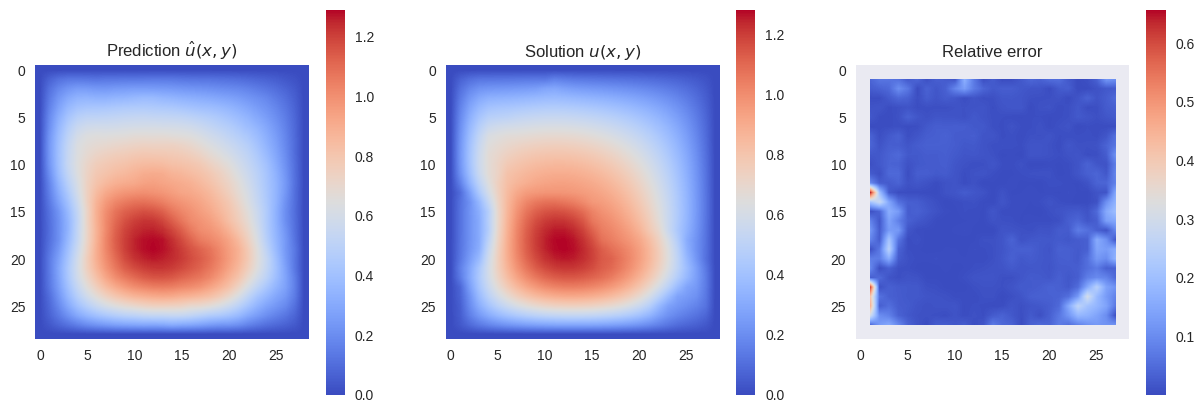

In [17]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

/tmp/ipykernel_15431/2060420217.py:17: RuntimeWarning: invalid value encountered in true_divide
  im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")


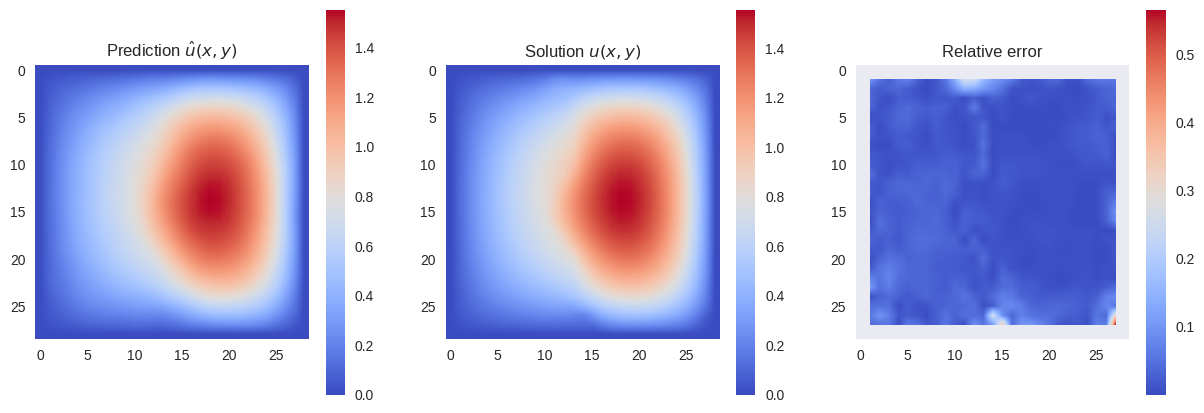

In [82]:
idx = 101
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: Matern, PCA 0.99

In [67]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
#kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

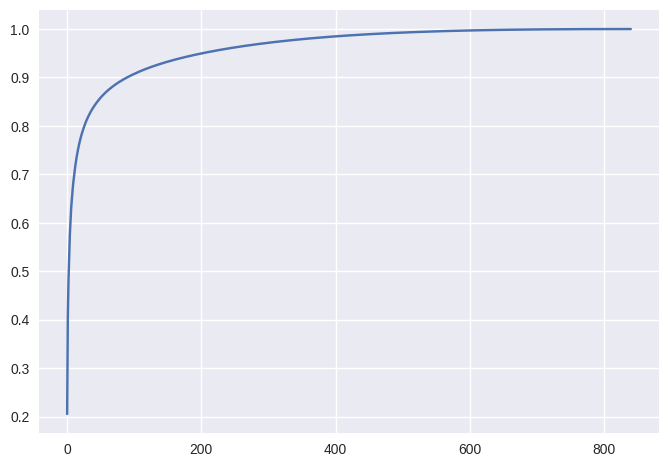

459

In [68]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n_pca

In [69]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

KeyboardInterrupt: 

In [ ]:
model.kernel_, e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: Rational Quadratic, PCA 0.99

In [ ]:
#kernel = Matern(nu = 2.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

In [ ]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n_pca

In [ ]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [ ]:
model.kernel_, e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()

# Gaussian Process: Rational Quadratic, PCA 0.90

In [ ]:
#kernel = Matern(nu = 2.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

In [ ]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]
n_pca

In [ ]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [ ]:
model.kernel_, e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow(np.sqrt((sol - sol_pred)**2/(sol)**2), interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Relative error")

plt.show()